# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install opencv-python-headless==4.1.2.30
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import pickle

from google.colab.patches import cv2_imshow

from PIL import Image
from google.colab import drive

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization, BatchNormalization, Input, concatenate, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img, image_dataset_from_directory

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')
sns.set_context('paper')
%config InlineBackend.figure_format = 'retina'

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/train_val')
print(os.getcwd())



  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-d28lsxgt
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-d28lsxgt
     |████████████████████████████████| 47.8 MB 13.3 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=295851408a0bbb7a2efe91d2f02a5fcd86c293583d91672957dc5e919e933b20
  Stored in directory: /tmp/pip-ephem-wheel-cache-d8_uoeze/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 21.8 MB 2.1 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalle

## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

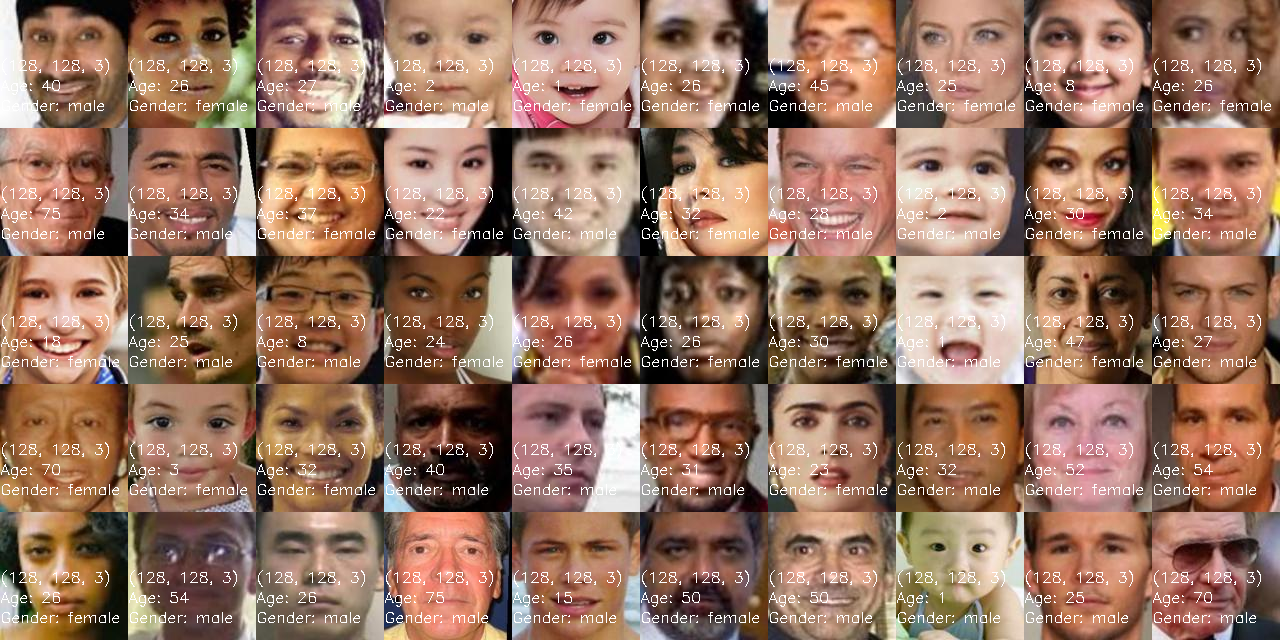

In [ ]:
images = glob.glob("*")
image_row = []
image_matrix = []

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
fontColor = (255,255,255)
thickness = 1
lineType = 2

for j in range(0,10):
  for i in range(0,5):
    file = images[(10*j)+i]
    age = file.split('_')[0]
    gender = ['male', 'female'][int(file.split('_')[1])]
    image = cv2.imread(file)
    cv2.putText(image,str(image.shape), (0,70), font, fontScale,fontColor,thickness,lineType)
    cv2.putText(image,'Age: ' +str(age), (0,90), font, fontScale,fontColor,thickness,lineType)
    cv2.putText(image,'Gender: '+gender, (0,110), font, fontScale,fontColor,thickness,lineType)
    image_row.append(image)
  image_matrix.append(cv2.vconcat(image_row))
  image_row = []
# show the image, provide window name first
cv2_imshow(cv2.hconcat(image_matrix))

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
def process():
  '''
  Process the image folder such that we can easily manage through a dataframe.
  '''
  df = pd.DataFrame()
  df['filename'] = [os.path.basename(file) for file in glob.glob('*.jpg')]

  for i, col in enumerate(['age', 'gender', 'race']):
    df[f'{col}'] = df['filename'].str.split('_').apply(lambda x: x[i]).astype(int)

  q_value = 10
  # Bin the data by age to stratify the split
  df['age_bins'] = pd.qcut(df['age'], q=q_value, precision=2, duplicates='drop')
  df['age_bins_encoded'] = \
    pd.qcut(df['age'], q=q_value, precision=2, labels=range(q_value), duplicates='drop').astype(int)
  # Age OHE
  from tensorflow.keras.utils import to_categorical
  age_ohe = to_categorical(df['age_bins_encoded'].values)
  df['age_bins_ohe'] = age_ohe.tolist()
  return df


def train_test_val_split(df, train_ratio=0.9, validation_ratio=0.05, test_ratio=0.05, stratify=None):
  '''Dataframe Train test val (holdout) split. Stratify by col name.'''
  if stratify is None:
    df_train, df_test, _, _ = \
    train_test_split(df, df, test_size=1-train_ratio)

    df_val, df_test, _, _ = \
      train_test_split(df_test, df_test, test_size=test_ratio/(test_ratio + validation_ratio))
    return df_train, df_test, df_val

  df_train, df_test, _, _ = \
    train_test_split(df, df, test_size=1-train_ratio, stratify=df[f'{stratify}'])

  df_val, df_test, _, _ = \
    train_test_split(df_test, df_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=df_test[f'{stratify}'])

  return df_train, df_test, df_val


df = process()
df_train, df_test, df_val = \
  train_test_val_split(df, stratify='age_bins_encoded')
display(df_train, df_train['age_bins'].value_counts(normalize=True))


filename  age  gender  race       age_bins  \
2131  47_1_0_20170109220604136.jpg.chip.jpg   47       1     0   (40.0, 50.0]   
3453   5_1_0_20170109193659649.jpg.chip.jpg    5       1     0    (0.99, 5.0]   
3303  14_0_0_20170110232523770.jpg.chip.jpg   14       0     0    (5.0, 20.0]   
4306  35_1_4_20170117200719931.jpg.chip.jpg   35       1     4   (34.0, 40.0]   
768   38_0_1_20170113152121359.jpg.chip.jpg   38       0     1   (34.0, 40.0]   
...                                     ...  ...     ...   ...            ...   
662   50_0_0_20170117172141491.jpg.chip.jpg   50       0     0   (40.0, 50.0]   
3680  80_0_0_20170111205531200.jpg.chip.jpg   80       0     0  (61.0, 116.0]   
1313  24_0_2_20170116164343289.jpg.chip.jpg   24       0     2   (20.0, 25.0]   
83    52_1_0_20170104185832638.jpg.chip.jpg   52       1     0   (50.0, 61.0]   
3092  56_0_0_20170104212551397.jpg.chip.jpg   56       0     0   (50.0, 61.0]   

      age_bins_encoded                                       age_bins_ohe  
2131                 7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...  
3453                 0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3303                 1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4306                 6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
768                  6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
...                ...                                                ...  
662                  7  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...  
3680                 9  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1313                 2  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
83                   8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  
3092                 8  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  

[4500 rows x 7 columns]

(20.0, 25.0]     0.118667
(34.0, 40.0]     0.116444
(5.0, 20.0]      0.106000
(25.0, 26.0]     0.103333
(0.99, 5.0]      0.100667
(50.0, 61.0]     0.098000
(29.0, 34.0]     0.096889
(61.0, 116.0]    0.094667
(40.0, 50.0]     0.084667
(26.0, 29.0]     0.080667
Name: age_bins, dtype: float64

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

Found 4500 validated image filenames.
Found 250 validated image filenames.
Found 250 validated image filenames.


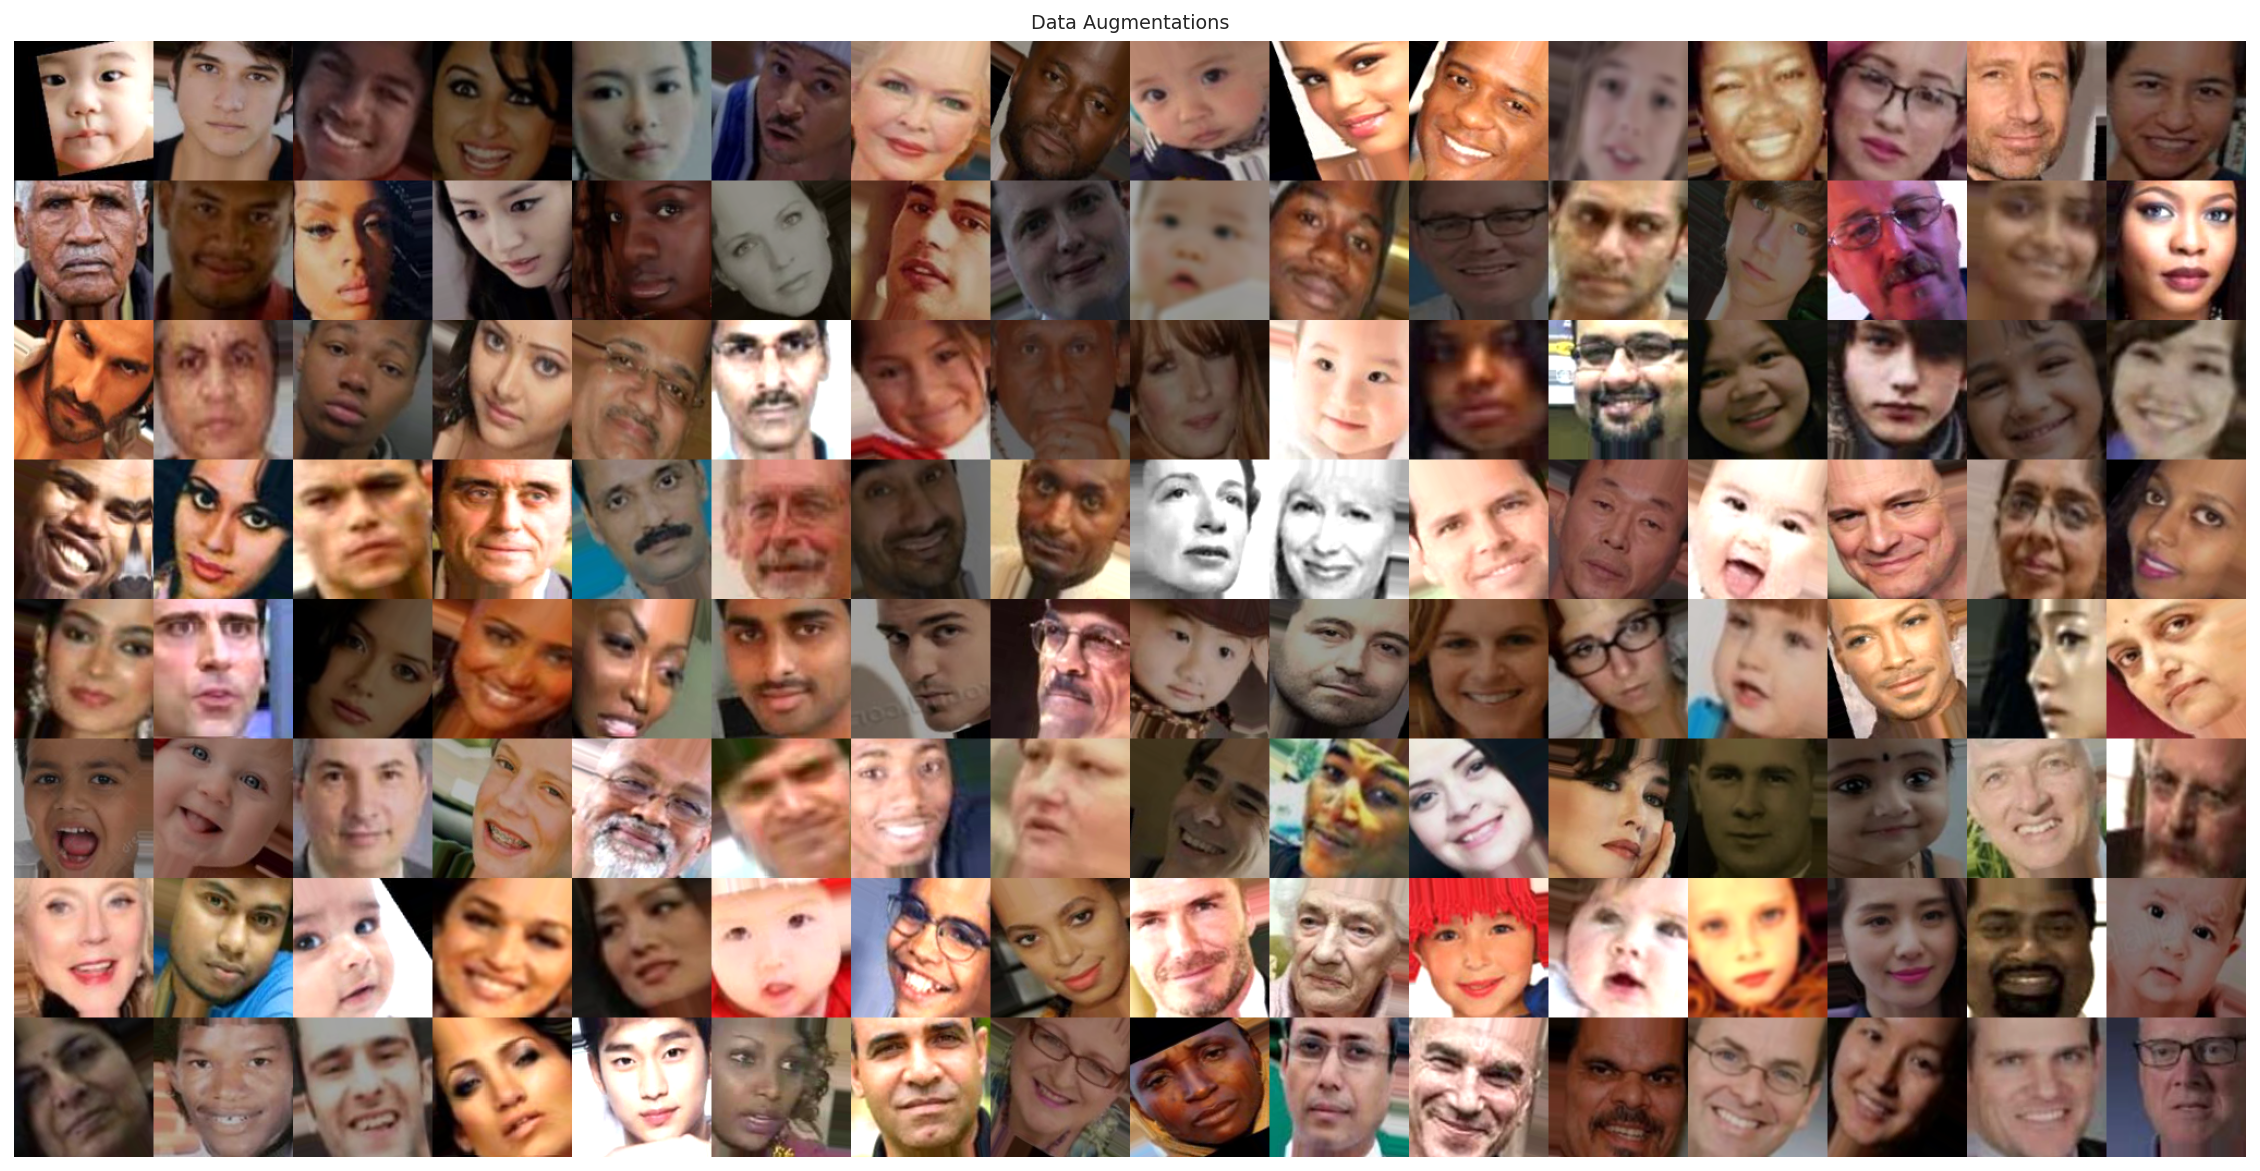

In [ ]:

import albumentations as A

def random_aug(img, p=0.05):
    '''Apply Augs'''
    transform = A.Compose([
    A.Blur(p=p),
    A.GridDistortion(p=p)
    ])
    return transform(image=img)["image"]


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.4,1.4],
    preprocessing_function=random_aug
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

data_gen_args = dict(
    directory=None,
    x_col='filename',
    y_col=['age', 'gender'],
    target_size=(128,128),
    batch_size=128,
    class_mode='multi_output',
)

# Train
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    **data_gen_args
)

# Validation
validation_generator = val_datagen.flow_from_dataframe(
    df_val,
    shuffle=False,
    **data_gen_args
)


test_datagen = ImageDataGenerator(rescale=1./255)
# Test
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    **data_gen_args,
    shuffle=False
)

def gallery(array, ncols=16):
    '''Create a photo gallery.'''
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert (nindex == nrows*ncols), 'Batch must be divisible by ncols.'
    
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    # Plot
    fig, ax = plt.subplots(figsize=(20., 20.))
    plt.axis('off')
    plt.title('Data Augmentations')
    plt.imshow(result)

gallery(train_generator[0][0])

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

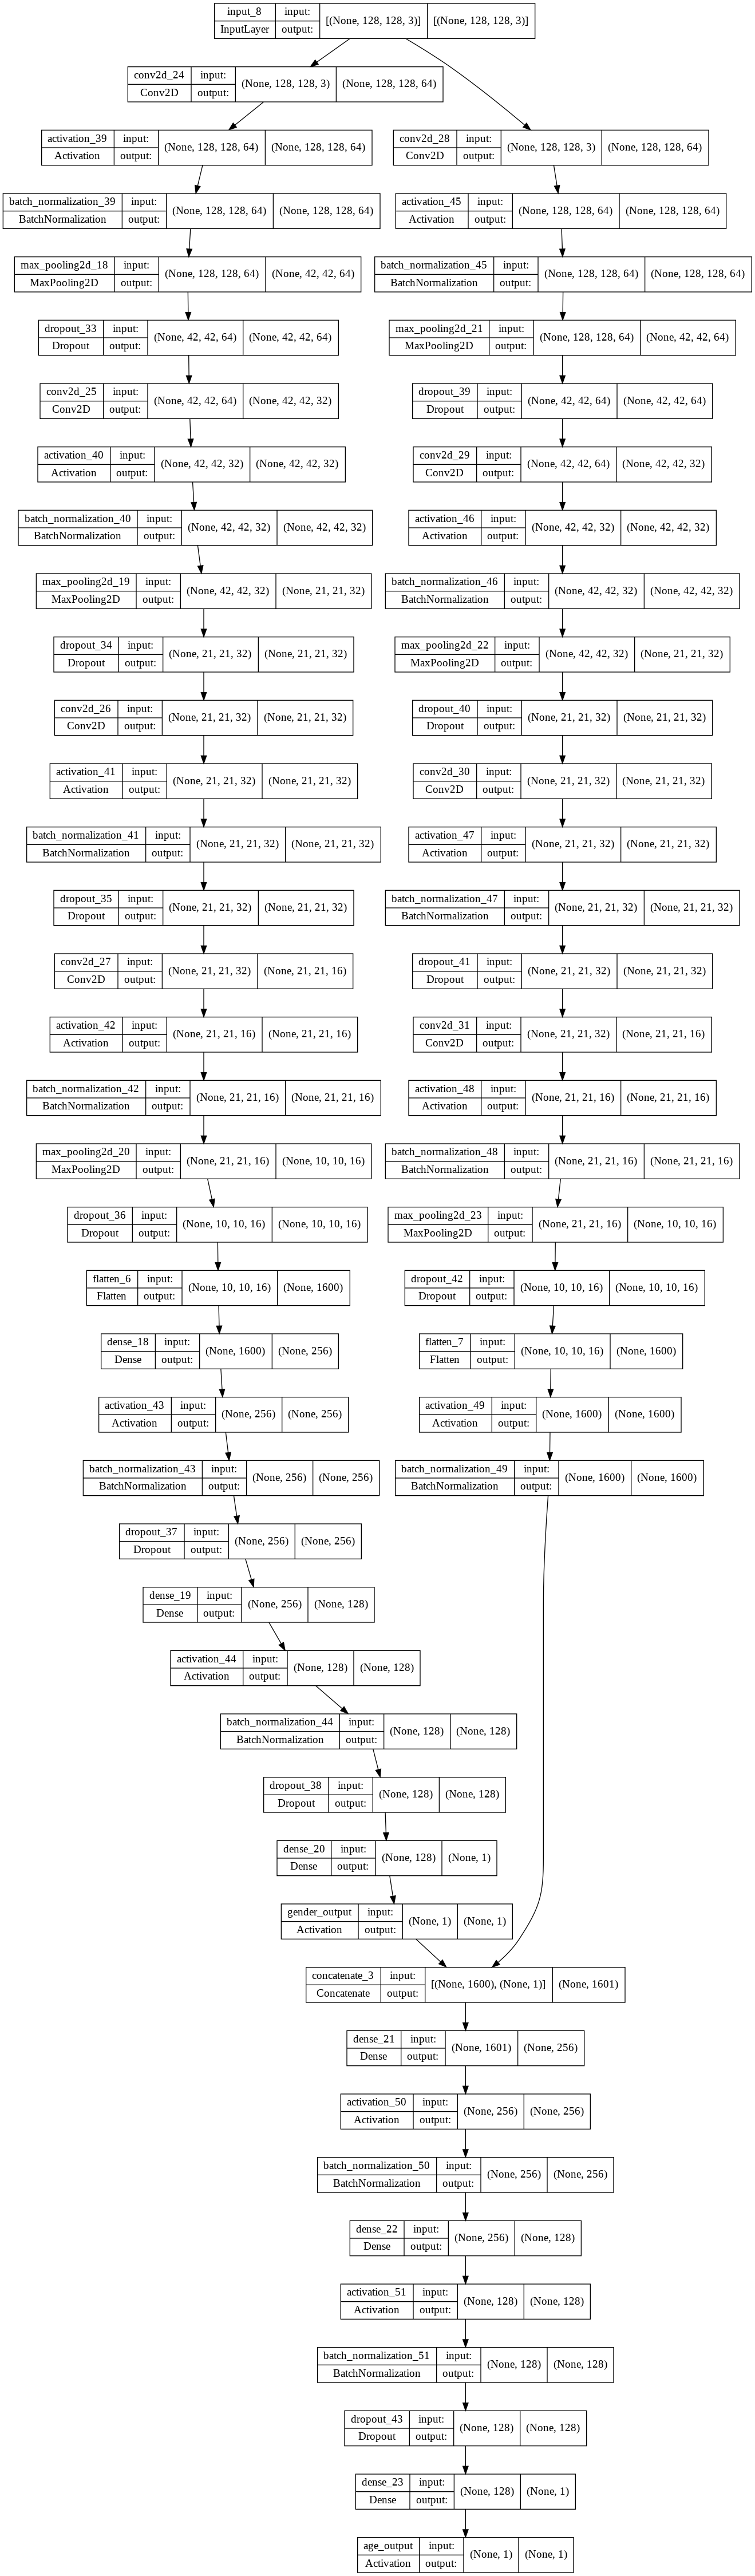

In [ ]:
class MultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains two branches, one for age, other for 
    sex. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> Pooling -> Dropout
        """
        x = Conv2D(64, (5, 5), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.1)(x)
        x = Conv2D(32, (5, 5), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.1)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        
        x = Dropout(0.1)(x)
        x = Conv2D(16, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.1)(x)
        return x
    def build_gender_branch(self, inputs):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)

        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dropout(0.1)(x)
        
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dropout(0.1)(x)

        x = Dense(1)(x)
        x = Activation("sigmoid", name="gender_output")(x)
        return x
    def build_age_branch(self, inputs, gender_branch):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)

        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = concatenate([x, gender_branch])

        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)

        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)

        x = Dropout(0.1)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)
        return x
    def assemble_full_model(self):
        """
        Used to assemble our multi-output model CNN.
        """
        inputs = Input(shape=(128,128,3))
        scale_layer = keras.layers.Rescaling(scale=1./255, offset=0)
        inputs = scale_layer(inputs)
        gender_branch = self.build_gender_branch(inputs)
        age_branch = self.build_age_branch(inputs, gender_branch)
        model = Model(inputs=inputs,
                     outputs = [
                         age_branch,
                         gender_branch],
                     name="face_net")
        return model

modelA = MultiOutputModel().assemble_full_model()

from keras.utils.vis_utils import plot_model

plot_model(modelA, to_file='/content/drive/My Drive/model_plot.png', show_shapes=True, show_layer_names=True)


## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [ ]:

initial_learning_rate = 0.008
epochs = 250

tf.debugging.set_log_device_placement(True)

modelA = MultiOutputModel().assemble_full_model()

modelA.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
    amsgrad=True, epsilon = 0.1
    ), 
    loss={
        'age_output': 'mse', 
        'gender_output': 'binary_crossentropy'
        },
    loss_weights={
        'age_output': 1.,
        'gender_output': 150.
        },
    metrics={
        'age_output': 'mae',
        'gender_output': 'accuracy'
        },
)

callbacks = [
    ModelCheckpoint('/content/drive/My Drive/model_checkpoint', monitor='val_loss'),
    tf.keras.callbacks.BackupAndRestore('/content/drive/My Drive/backup_finals')
]

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = modelA.fit(
    train_generator, 
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs, 
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=callbacks
)


with open('/content/drive/My Drive/trainHistoryDict_A.hdf5', 'wb') as file_:
        pickle.dump(history.history, file_)

modelA.save("/content/drive/My Drive/age_gender_A.h5")
modelA = load_model("/content/drive/My Drive/age_gender_A.h5")

ys = modelA.evaluate_generator(
    generator=validation_generator,  
    steps=STEP_SIZE_VALID
)
print(ys)


Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 125.9350 - age_output_loss: 93.6457 - gender_output_loss: 0.2153 - age_output_mae: 7.0454 - gender_output_accuracy: 0.9124INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 50s 1s/step - loss: 125.9350 - age_output_loss: 93.6457 - gender_output_loss: 0.2153 - age_output_mae: 7.0454 - gender_output_accuracy: 0.9124 - val_loss: 79.7062 - val_age_output_loss: 59.3040 - val_gender_output_loss: 0.1360 - val_age_output_mae: 5.8281 - val_gender_output_accuracy: 0.9219
Epoch 2/50
35/35 [==============================] - ETA: 0s - loss: 121.4663 - age_output_loss: 86.5579 - gender_output_loss: 0.2327 - age_output_mae: 6.7863 - gender_output_accuracy: 0.9007INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 47s 1s/step - loss: 121.4663 - age_output_loss: 86.5579 - gender_output_loss: 0.2327 - age_output_mae: 6.7863 - gender_output_accuracy: 0.9007 - val_loss: 93.1991 - val_age_output_loss: 43.3745 - val_gender_output_loss: 0.3322 - val_age_output_mae: 5.2142 - val_gender_output_accuracy: 0.8281
Epoch 3/50
35/35 [==============================] - ETA: 0s - loss: 123.0723 - age_output_loss: 88.0709 - gender_output_loss: 0.2333 - age_output_mae: 6.8852 - gender_output_accuracy: 0.9000INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 123.0723 - age_output_loss: 88.0709 - gender_output_loss: 0.2333 - age_output_mae: 6.8852 - gender_output_accuracy: 0.9000 - val_loss: 73.2854 - val_age_output_loss: 51.3138 - val_gender_output_loss: 0.1465 - val_age_output_mae: 5.5237 - val_gender_output_accuracy: 0.9609
Epoch 4/50
35/35 [==============================] - ETA: 0s - loss: 139.8953 - age_output_loss: 88.1316 - gender_output_loss: 0.3451 - age_output_mae: 6.8505 - gender_output_accuracy: 0.8509INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 47s 1s/step - loss: 139.8953 - age_output_loss: 88.1316 - gender_output_loss: 0.3451 - age_output_mae: 6.8505 - gender_output_accuracy: 0.8509 - val_loss: 235.7519 - val_age_output_loss: 155.2698 - val_gender_output_loss: 0.5365 - val_age_output_mae: 10.1070 - val_gender_output_accuracy: 0.7500
Epoch 5/50
35/35 [==============================] - ETA: 0s - loss: 133.7804 - age_output_loss: 82.7984 - gender_output_loss: 0.3399 - age_output_mae: 6.7395 - gender_output_accuracy: 0.8513INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 133.7804 - age_output_loss: 82.7984 - gender_output_loss: 0.3399 - age_output_mae: 6.7395 - gender_output_accuracy: 0.8513 - val_loss: 95.8319 - val_age_output_loss: 58.0768 - val_gender_output_loss: 0.2517 - val_age_output_mae: 5.9459 - val_gender_output_accuracy: 0.8984
Epoch 6/50
35/35 [==============================] - ETA: 0s - loss: 132.8230 - age_output_loss: 87.8590 - gender_output_loss: 0.2998 - age_output_mae: 6.8640 - gender_output_accuracy: 0.8685INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 132.8230 - age_output_loss: 87.8590 - gender_output_loss: 0.2998 - age_output_mae: 6.8640 - gender_output_accuracy: 0.8685 - val_loss: 95.5211 - val_age_output_loss: 69.5852 - val_gender_output_loss: 0.1729 - val_age_output_mae: 6.7079 - val_gender_output_accuracy: 0.9297
Epoch 7/50
35/35 [==============================] - ETA: 0s - loss: 123.4615 - age_output_loss: 83.5000 - gender_output_loss: 0.2664 - age_output_mae: 6.8095 - gender_output_accuracy: 0.8859INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 123.4615 - age_output_loss: 83.5000 - gender_output_loss: 0.2664 - age_output_mae: 6.8095 - gender_output_accuracy: 0.8859 - val_loss: 98.9717 - val_age_output_loss: 73.8230 - val_gender_output_loss: 0.1677 - val_age_output_mae: 6.9198 - val_gender_output_accuracy: 0.9375
Epoch 8/50
35/35 [==============================] - ETA: 0s - loss: 118.7587 - age_output_loss: 81.5849 - gender_output_loss: 0.2478 - age_output_mae: 6.6739 - gender_output_accuracy: 0.8895INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 118.7587 - age_output_loss: 81.5849 - gender_output_loss: 0.2478 - age_output_mae: 6.6739 - gender_output_accuracy: 0.8895 - val_loss: 87.3052 - val_age_output_loss: 69.4138 - val_gender_output_loss: 0.1193 - val_age_output_mae: 6.4971 - val_gender_output_accuracy: 0.9609
Epoch 9/50
35/35 [==============================] - ETA: 0s - loss: 118.3006 - age_output_loss: 83.1680 - gender_output_loss: 0.2342 - age_output_mae: 6.7381 - gender_output_accuracy: 0.9023INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 118.3006 - age_output_loss: 83.1680 - gender_output_loss: 0.2342 - age_output_mae: 6.7381 - gender_output_accuracy: 0.9023 - val_loss: 81.9254 - val_age_output_loss: 64.9213 - val_gender_output_loss: 0.1134 - val_age_output_mae: 6.3433 - val_gender_output_accuracy: 0.9688
Epoch 10/50
35/35 [==============================] - ETA: 0s - loss: 129.9293 - age_output_loss: 91.3395 - gender_output_loss: 0.2573 - age_output_mae: 7.0118 - gender_output_accuracy: 0.8891INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 47s 1s/step - loss: 129.9293 - age_output_loss: 91.3395 - gender_output_loss: 0.2573 - age_output_mae: 7.0118 - gender_output_accuracy: 0.8891 - val_loss: 82.6398 - val_age_output_loss: 54.8826 - val_gender_output_loss: 0.1850 - val_age_output_mae: 5.6300 - val_gender_output_accuracy: 0.9141
Epoch 11/50
35/35 [==============================] - ETA: 0s - loss: 124.3333 - age_output_loss: 87.2288 - gender_output_loss: 0.2474 - age_output_mae: 6.8936 - gender_output_accuracy: 0.8927INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 124.3333 - age_output_loss: 87.2288 - gender_output_loss: 0.2474 - age_output_mae: 6.8936 - gender_output_accuracy: 0.8927 - val_loss: 183.1125 - val_age_output_loss: 159.2760 - val_gender_output_loss: 0.1589 - val_age_output_mae: 8.6772 - val_gender_output_accuracy: 0.9297
Epoch 12/50
35/35 [==============================] - ETA: 0s - loss: 119.9033 - age_output_loss: 84.2659 - gender_output_loss: 0.2376 - age_output_mae: 6.8426 - gender_output_accuracy: 0.8948INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 119.9033 - age_output_loss: 84.2659 - gender_output_loss: 0.2376 - age_output_mae: 6.8426 - gender_output_accuracy: 0.8948 - val_loss: 81.6760 - val_age_output_loss: 57.1915 - val_gender_output_loss: 0.1632 - val_age_output_mae: 5.9026 - val_gender_output_accuracy: 0.9609
Epoch 13/50
35/35 [==============================] - ETA: 0s - loss: 121.2791 - age_output_loss: 86.2453 - gender_output_loss: 0.2336 - age_output_mae: 6.7783 - gender_output_accuracy: 0.8987INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 121.2791 - age_output_loss: 86.2453 - gender_output_loss: 0.2336 - age_output_mae: 6.7783 - gender_output_accuracy: 0.8987 - val_loss: 86.6612 - val_age_output_loss: 67.4667 - val_gender_output_loss: 0.1280 - val_age_output_mae: 6.1866 - val_gender_output_accuracy: 0.9531
Epoch 14/50
35/35 [==============================] - ETA: 0s - loss: 122.7998 - age_output_loss: 89.3909 - gender_output_loss: 0.2227 - age_output_mae: 7.0454 - gender_output_accuracy: 0.9071INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 122.7998 - age_output_loss: 89.3909 - gender_output_loss: 0.2227 - age_output_mae: 7.0454 - gender_output_accuracy: 0.9071 - val_loss: 96.9666 - val_age_output_loss: 73.8359 - val_gender_output_loss: 0.1542 - val_age_output_mae: 6.5369 - val_gender_output_accuracy: 0.9531
Epoch 15/50
35/35 [==============================] - ETA: 0s - loss: 120.6689 - age_output_loss: 86.1495 - gender_output_loss: 0.2301 - age_output_mae: 6.8359 - gender_output_accuracy: 0.8994INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 120.6689 - age_output_loss: 86.1495 - gender_output_loss: 0.2301 - age_output_mae: 6.8359 - gender_output_accuracy: 0.8994 - val_loss: 136.6916 - val_age_output_loss: 117.7898 - val_gender_output_loss: 0.1260 - val_age_output_mae: 8.5199 - val_gender_output_accuracy: 0.9688
Epoch 16/50
35/35 [==============================] - ETA: 0s - loss: 118.3169 - age_output_loss: 83.8334 - gender_output_loss: 0.2299 - age_output_mae: 6.7657 - gender_output_accuracy: 0.9039INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 118.3169 - age_output_loss: 83.8334 - gender_output_loss: 0.2299 - age_output_mae: 6.7657 - gender_output_accuracy: 0.9039 - val_loss: 88.4381 - val_age_output_loss: 67.3040 - val_gender_output_loss: 0.1409 - val_age_output_mae: 6.3938 - val_gender_output_accuracy: 0.9453
Epoch 17/50
35/35 [==============================] - ETA: 0s - loss: 116.3181 - age_output_loss: 83.2457 - gender_output_loss: 0.2205 - age_output_mae: 6.8056 - gender_output_accuracy: 0.9090INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 116.3181 - age_output_loss: 83.2457 - gender_output_loss: 0.2205 - age_output_mae: 6.8056 - gender_output_accuracy: 0.9090 - val_loss: 90.0695 - val_age_output_loss: 69.4909 - val_gender_output_loss: 0.1372 - val_age_output_mae: 6.2676 - val_gender_output_accuracy: 0.9609
Epoch 18/50
35/35 [==============================] - ETA: 0s - loss: 113.9407 - age_output_loss: 81.1603 - gender_output_loss: 0.2185 - age_output_mae: 6.6877 - gender_output_accuracy: 0.9048INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 113.9407 - age_output_loss: 81.1603 - gender_output_loss: 0.2185 - age_output_mae: 6.6877 - gender_output_accuracy: 0.9048 - val_loss: 127.4354 - val_age_output_loss: 110.4461 - val_gender_output_loss: 0.1133 - val_age_output_mae: 8.3204 - val_gender_output_accuracy: 0.9688
Epoch 19/50
35/35 [==============================] - ETA: 0s - loss: 110.7142 - age_output_loss: 78.5039 - gender_output_loss: 0.2147 - age_output_mae: 6.5393 - gender_output_accuracy: 0.9131INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 47s 1s/step - loss: 110.7142 - age_output_loss: 78.5039 - gender_output_loss: 0.2147 - age_output_mae: 6.5393 - gender_output_accuracy: 0.9131 - val_loss: 76.8650 - val_age_output_loss: 55.8891 - val_gender_output_loss: 0.1398 - val_age_output_mae: 5.9782 - val_gender_output_accuracy: 0.9375
Epoch 20/50
35/35 [==============================] - ETA: 0s - loss: 116.2404 - age_output_loss: 84.3118 - gender_output_loss: 0.2129 - age_output_mae: 6.7829 - gender_output_accuracy: 0.9078INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 116.2404 - age_output_loss: 84.3118 - gender_output_loss: 0.2129 - age_output_mae: 6.7829 - gender_output_accuracy: 0.9078 - val_loss: 77.1531 - val_age_output_loss: 57.8999 - val_gender_output_loss: 0.1284 - val_age_output_mae: 5.9877 - val_gender_output_accuracy: 0.9609
Epoch 21/50
35/35 [==============================] - ETA: 0s - loss: 114.7471 - age_output_loss: 82.5543 - gender_output_loss: 0.2146 - age_output_mae: 6.8153 - gender_output_accuracy: 0.9071INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 114.7471 - age_output_loss: 82.5543 - gender_output_loss: 0.2146 - age_output_mae: 6.8153 - gender_output_accuracy: 0.9071 - val_loss: 79.3663 - val_age_output_loss: 63.0497 - val_gender_output_loss: 0.1088 - val_age_output_mae: 6.3183 - val_gender_output_accuracy: 0.9688
Epoch 22/50
35/35 [==============================] - ETA: 0s - loss: 116.1218 - age_output_loss: 85.1560 - gender_output_loss: 0.2064 - age_output_mae: 6.8270 - gender_output_accuracy: 0.9131INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 47s 1s/step - loss: 116.1218 - age_output_loss: 85.1560 - gender_output_loss: 0.2064 - age_output_mae: 6.8270 - gender_output_accuracy: 0.9131 - val_loss: 142.5230 - val_age_output_loss: 120.6168 - val_gender_output_loss: 0.1460 - val_age_output_mae: 8.8247 - val_gender_output_accuracy: 0.9531
Epoch 23/50
35/35 [==============================] - ETA: 0s - loss: 115.3424 - age_output_loss: 82.4113 - gender_output_loss: 0.2195 - age_output_mae: 6.7359 - gender_output_accuracy: 0.9103INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 115.3424 - age_output_loss: 82.4113 - gender_output_loss: 0.2195 - age_output_mae: 6.7359 - gender_output_accuracy: 0.9103 - val_loss: 162.7697 - val_age_output_loss: 79.8165 - val_gender_output_loss: 0.5530 - val_age_output_mae: 6.7243 - val_gender_output_accuracy: 0.7344
Epoch 24/50
35/35 [==============================] - ETA: 0s - loss: 139.4003 - age_output_loss: 86.9767 - gender_output_loss: 0.3495 - age_output_mae: 6.8864 - gender_output_accuracy: 0.8474INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 139.4003 - age_output_loss: 86.9767 - gender_output_loss: 0.3495 - age_output_mae: 6.8864 - gender_output_accuracy: 0.8474 - val_loss: 128.7303 - val_age_output_loss: 84.7795 - val_gender_output_loss: 0.2930 - val_age_output_mae: 6.9324 - val_gender_output_accuracy: 0.8984
Epoch 25/50
35/35 [==============================] - ETA: 0s - loss: 129.1417 - age_output_loss: 84.7228 - gender_output_loss: 0.2961 - age_output_mae: 6.7604 - gender_output_accuracy: 0.8671INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 129.1417 - age_output_loss: 84.7228 - gender_output_loss: 0.2961 - age_output_mae: 6.7604 - gender_output_accuracy: 0.8671 - val_loss: 112.3490 - val_age_output_loss: 78.7072 - val_gender_output_loss: 0.2243 - val_age_output_mae: 6.8072 - val_gender_output_accuracy: 0.9062
Epoch 26/50
35/35 [==============================] - ETA: 0s - loss: 119.8269 - age_output_loss: 81.2588 - gender_output_loss: 0.2571 - age_output_mae: 6.6340 - gender_output_accuracy: 0.8863INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 119.8269 - age_output_loss: 81.2588 - gender_output_loss: 0.2571 - age_output_mae: 6.6340 - gender_output_accuracy: 0.8863 - val_loss: 95.0596 - val_age_output_loss: 61.9194 - val_gender_output_loss: 0.2209 - val_age_output_mae: 5.8633 - val_gender_output_accuracy: 0.9219
Epoch 27/50
35/35 [==============================] - ETA: 0s - loss: 115.3985 - age_output_loss: 77.7999 - gender_output_loss: 0.2507 - age_output_mae: 6.4935 - gender_output_accuracy: 0.8932INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 115.3985 - age_output_loss: 77.7999 - gender_output_loss: 0.2507 - age_output_mae: 6.4935 - gender_output_accuracy: 0.8932 - val_loss: 93.8276 - val_age_output_loss: 65.4147 - val_gender_output_loss: 0.1894 - val_age_output_mae: 6.0041 - val_gender_output_accuracy: 0.9219
Epoch 28/50
35/35 [==============================] - ETA: 0s - loss: 120.7140 - age_output_loss: 86.7372 - gender_output_loss: 0.2265 - age_output_mae: 6.8701 - gender_output_accuracy: 0.9021INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 120.7140 - age_output_loss: 86.7372 - gender_output_loss: 0.2265 - age_output_mae: 6.8701 - gender_output_accuracy: 0.9021 - val_loss: 97.2400 - val_age_output_loss: 71.9560 - val_gender_output_loss: 0.1686 - val_age_output_mae: 6.2673 - val_gender_output_accuracy: 0.9297
Epoch 29/50
35/35 [==============================] - ETA: 0s - loss: 113.5270 - age_output_loss: 79.1865 - gender_output_loss: 0.2289 - age_output_mae: 6.6069 - gender_output_accuracy: 0.9026INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 113.5270 - age_output_loss: 79.1865 - gender_output_loss: 0.2289 - age_output_mae: 6.6069 - gender_output_accuracy: 0.9026 - val_loss: 76.6758 - val_age_output_loss: 51.6592 - val_gender_output_loss: 0.1668 - val_age_output_mae: 5.6114 - val_gender_output_accuracy: 0.9531
Epoch 30/50
35/35 [==============================] - ETA: 0s - loss: 115.0874 - age_output_loss: 79.1112 - gender_output_loss: 0.2398 - age_output_mae: 6.6581 - gender_output_accuracy: 0.9016INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 115.0874 - age_output_loss: 79.1112 - gender_output_loss: 0.2398 - age_output_mae: 6.6581 - gender_output_accuracy: 0.9016 - val_loss: 86.3949 - val_age_output_loss: 65.0452 - val_gender_output_loss: 0.1423 - val_age_output_mae: 6.2175 - val_gender_output_accuracy: 0.9453
Epoch 31/50
35/35 [==============================] - ETA: 0s - loss: 112.8450 - age_output_loss: 79.4830 - gender_output_loss: 0.2224 - age_output_mae: 6.5947 - gender_output_accuracy: 0.9044INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 112.8450 - age_output_loss: 79.4830 - gender_output_loss: 0.2224 - age_output_mae: 6.5947 - gender_output_accuracy: 0.9044 - val_loss: 77.8454 - val_age_output_loss: 57.2280 - val_gender_output_loss: 0.1374 - val_age_output_mae: 5.7137 - val_gender_output_accuracy: 0.9609
Epoch 32/50
35/35 [==============================] - ETA: 0s - loss: 117.2152 - age_output_loss: 81.1404 - gender_output_loss: 0.2405 - age_output_mae: 6.6941 - gender_output_accuracy: 0.8998INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 117.2152 - age_output_loss: 81.1404 - gender_output_loss: 0.2405 - age_output_mae: 6.6941 - gender_output_accuracy: 0.8998 - val_loss: 94.4903 - val_age_output_loss: 50.5878 - val_gender_output_loss: 0.2927 - val_age_output_mae: 5.5048 - val_gender_output_accuracy: 0.8750
Epoch 33/50
35/35 [==============================] - ETA: 0s - loss: 113.0217 - age_output_loss: 79.4671 - gender_output_loss: 0.2237 - age_output_mae: 6.5511 - gender_output_accuracy: 0.9062INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 113.0217 - age_output_loss: 79.4671 - gender_output_loss: 0.2237 - age_output_mae: 6.5511 - gender_output_accuracy: 0.9062 - val_loss: 250.6247 - val_age_output_loss: 231.2170 - val_gender_output_loss: 0.1294 - val_age_output_mae: 12.5786 - val_gender_output_accuracy: 0.9766
Epoch 34/50
35/35 [==============================] - ETA: 0s - loss: 115.3536 - age_output_loss: 82.1723 - gender_output_loss: 0.2212 - age_output_mae: 6.6726 - gender_output_accuracy: 0.9069INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 115.3536 - age_output_loss: 82.1723 - gender_output_loss: 0.2212 - age_output_mae: 6.6726 - gender_output_accuracy: 0.9069 - val_loss: 82.8571 - val_age_output_loss: 58.8951 - val_gender_output_loss: 0.1597 - val_age_output_mae: 6.1837 - val_gender_output_accuracy: 0.9453
Epoch 35/50
35/35 [==============================] - ETA: 0s - loss: 112.6672 - age_output_loss: 80.6153 - gender_output_loss: 0.2137 - age_output_mae: 6.6657 - gender_output_accuracy: 0.9122INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 112.6672 - age_output_loss: 80.6153 - gender_output_loss: 0.2137 - age_output_mae: 6.6657 - gender_output_accuracy: 0.9122 - val_loss: 99.7932 - val_age_output_loss: 80.6105 - val_gender_output_loss: 0.1279 - val_age_output_mae: 6.7945 - val_gender_output_accuracy: 0.9688
Epoch 36/50
35/35 [==============================] - ETA: 0s - loss: 116.4842 - age_output_loss: 83.8949 - gender_output_loss: 0.2173 - age_output_mae: 6.7233 - gender_output_accuracy: 0.9032INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 116.4842 - age_output_loss: 83.8949 - gender_output_loss: 0.2173 - age_output_mae: 6.7233 - gender_output_accuracy: 0.9032 - val_loss: 81.8014 - val_age_output_loss: 54.5073 - val_gender_output_loss: 0.1820 - val_age_output_mae: 5.6889 - val_gender_output_accuracy: 0.9531
Epoch 37/50
35/35 [==============================] - ETA: 0s - loss: 115.0495 - age_output_loss: 82.3554 - gender_output_loss: 0.2180 - age_output_mae: 6.7112 - gender_output_accuracy: 0.9069INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 115.0495 - age_output_loss: 82.3554 - gender_output_loss: 0.2180 - age_output_mae: 6.7112 - gender_output_accuracy: 0.9069 - val_loss: 83.7230 - val_age_output_loss: 55.4785 - val_gender_output_loss: 0.1883 - val_age_output_mae: 5.7260 - val_gender_output_accuracy: 0.9453
Epoch 38/50
35/35 [==============================] - ETA: 0s - loss: 109.7253 - age_output_loss: 78.4375 - gender_output_loss: 0.2086 - age_output_mae: 6.6048 - gender_output_accuracy: 0.9147INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 109.7253 - age_output_loss: 78.4375 - gender_output_loss: 0.2086 - age_output_mae: 6.6048 - gender_output_accuracy: 0.9147 - val_loss: 90.6889 - val_age_output_loss: 67.8175 - val_gender_output_loss: 0.1525 - val_age_output_mae: 6.3274 - val_gender_output_accuracy: 0.9609
Epoch 39/50
35/35 [==============================] - ETA: 0s - loss: 113.9687 - age_output_loss: 82.5045 - gender_output_loss: 0.2098 - age_output_mae: 6.6861 - gender_output_accuracy: 0.9138INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 113.9687 - age_output_loss: 82.5045 - gender_output_loss: 0.2098 - age_output_mae: 6.6861 - gender_output_accuracy: 0.9138 - val_loss: 68.7270 - val_age_output_loss: 51.0871 - val_gender_output_loss: 0.1176 - val_age_output_mae: 5.7013 - val_gender_output_accuracy: 0.9609
Epoch 40/50
35/35 [==============================] - ETA: 0s - loss: 105.4534 - age_output_loss: 74.1243 - gender_output_loss: 0.2089 - age_output_mae: 6.3376 - gender_output_accuracy: 0.9154INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 105.4534 - age_output_loss: 74.1243 - gender_output_loss: 0.2089 - age_output_mae: 6.3376 - gender_output_accuracy: 0.9154 - val_loss: 72.6570 - val_age_output_loss: 53.4062 - val_gender_output_loss: 0.1283 - val_age_output_mae: 5.7359 - val_gender_output_accuracy: 0.9688
Epoch 41/50
35/35 [==============================] - ETA: 0s - loss: 108.7975 - age_output_loss: 78.0665 - gender_output_loss: 0.2049 - age_output_mae: 6.5430 - gender_output_accuracy: 0.9133INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 108.7975 - age_output_loss: 78.0665 - gender_output_loss: 0.2049 - age_output_mae: 6.5430 - gender_output_accuracy: 0.9133 - val_loss: 76.6427 - val_age_output_loss: 56.3302 - val_gender_output_loss: 0.1354 - val_age_output_mae: 5.7290 - val_gender_output_accuracy: 0.9609
Epoch 42/50
35/35 [==============================] - ETA: 0s - loss: 108.5554 - age_output_loss: 78.0437 - gender_output_loss: 0.2034 - age_output_mae: 6.5376 - gender_output_accuracy: 0.9149INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 47s 1s/step - loss: 108.5554 - age_output_loss: 78.0437 - gender_output_loss: 0.2034 - age_output_mae: 6.5376 - gender_output_accuracy: 0.9149 - val_loss: 76.9407 - val_age_output_loss: 55.7556 - val_gender_output_loss: 0.1412 - val_age_output_mae: 5.7851 - val_gender_output_accuracy: 0.9609
Epoch 43/50
35/35 [==============================] - ETA: 0s - loss: 113.7961 - age_output_loss: 80.8509 - gender_output_loss: 0.2196 - age_output_mae: 6.6485 - gender_output_accuracy: 0.9100INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 113.7961 - age_output_loss: 80.8509 - gender_output_loss: 0.2196 - age_output_mae: 6.6485 - gender_output_accuracy: 0.9100 - val_loss: 75.3118 - val_age_output_loss: 56.7115 - val_gender_output_loss: 0.1240 - val_age_output_mae: 5.8641 - val_gender_output_accuracy: 0.9609
Epoch 44/50
35/35 [==============================] - ETA: 0s - loss: 111.2623 - age_output_loss: 79.2082 - gender_output_loss: 0.2137 - age_output_mae: 6.5819 - gender_output_accuracy: 0.9076INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 111.2623 - age_output_loss: 79.2082 - gender_output_loss: 0.2137 - age_output_mae: 6.5819 - gender_output_accuracy: 0.9076 - val_loss: 77.3978 - val_age_output_loss: 56.3382 - val_gender_output_loss: 0.1404 - val_age_output_mae: 5.8673 - val_gender_output_accuracy: 0.9609
Epoch 45/50
35/35 [==============================] - ETA: 0s - loss: 107.6460 - age_output_loss: 78.5584 - gender_output_loss: 0.1939 - age_output_mae: 6.5339 - gender_output_accuracy: 0.9213INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 107.6460 - age_output_loss: 78.5584 - gender_output_loss: 0.1939 - age_output_mae: 6.5339 - gender_output_accuracy: 0.9213 - val_loss: 130.9925 - val_age_output_loss: 107.0172 - val_gender_output_loss: 0.1598 - val_age_output_mae: 8.2316 - val_gender_output_accuracy: 0.9609
Epoch 46/50
35/35 [==============================] - ETA: 0s - loss: 107.0823 - age_output_loss: 76.1109 - gender_output_loss: 0.2065 - age_output_mae: 6.3844 - gender_output_accuracy: 0.9119INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 47s 1s/step - loss: 107.0823 - age_output_loss: 76.1109 - gender_output_loss: 0.2065 - age_output_mae: 6.3844 - gender_output_accuracy: 0.9119 - val_loss: 82.0592 - val_age_output_loss: 63.1022 - val_gender_output_loss: 0.1264 - val_age_output_mae: 6.1532 - val_gender_output_accuracy: 0.9531
Epoch 47/50
35/35 [==============================] - ETA: 0s - loss: 104.3601 - age_output_loss: 75.9520 - gender_output_loss: 0.1894 - age_output_mae: 6.4484 - gender_output_accuracy: 0.9190INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 104.3601 - age_output_loss: 75.9520 - gender_output_loss: 0.1894 - age_output_mae: 6.4484 - gender_output_accuracy: 0.9190 - val_loss: 90.6342 - val_age_output_loss: 66.9088 - val_gender_output_loss: 0.1582 - val_age_output_mae: 6.3818 - val_gender_output_accuracy: 0.9297
Epoch 48/50
35/35 [==============================] - ETA: 0s - loss: 109.7739 - age_output_loss: 80.3390 - gender_output_loss: 0.1962 - age_output_mae: 6.6630 - gender_output_accuracy: 0.9174INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 109.7739 - age_output_loss: 80.3390 - gender_output_loss: 0.1962 - age_output_mae: 6.6630 - gender_output_accuracy: 0.9174 - val_loss: 87.5005 - val_age_output_loss: 66.6177 - val_gender_output_loss: 0.1392 - val_age_output_mae: 6.0257 - val_gender_output_accuracy: 0.9453
Epoch 49/50
35/35 [==============================] - ETA: 0s - loss: 109.0375 - age_output_loss: 78.1428 - gender_output_loss: 0.2060 - age_output_mae: 6.5682 - gender_output_accuracy: 0.9197INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 109.0375 - age_output_loss: 78.1428 - gender_output_loss: 0.2060 - age_output_mae: 6.5682 - gender_output_accuracy: 0.9197 - val_loss: 81.8465 - val_age_output_loss: 57.4661 - val_gender_output_loss: 0.1625 - val_age_output_mae: 6.0591 - val_gender_output_accuracy: 0.9062
Epoch 50/50
35/35 [==============================] - ETA: 0s - loss: 106.3370 - age_output_loss: 76.0885 - gender_output_loss: 0.2017 - age_output_mae: 6.4600 - gender_output_accuracy: 0.9172INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 47s 1s/step - loss: 106.3370 - age_output_loss: 76.0885 - gender_output_loss: 0.2017 - age_output_mae: 6.4600 - gender_output_accuracy: 0.9172 - val_loss: 79.6505 - val_age_output_loss: 56.6164 - val_gender_output_loss: 0.1536 - val_age_output_mae: 5.6482 - val_gender_output_accuracy: 0.9453


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


[79.65048217773438, 56.616397857666016, 0.1535605788230896, 5.648205757141113, 0.9453125]


In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
eval_valid = modelA.evaluate(
    validation_generator,
    steps=STEP_SIZE_VALID
)
eval_test = modelA.evaluate(
    test_generator,
    steps=STEP_SIZE_TEST
)

print(f'MAE of Age Estimation (Validation): {eval_valid[3]:.2f} yr')
print(f'Accuracy of Gender Classification (Validation): {eval_valid[4]*100:.2f}%')
print(f'MAE of Age Estimation (Test): {eval_test[3]:.2f} yr')
print(f'Accuracy of Gender Classification (Test): {eval_test[4]*100:.2f}%')

1/1 [==============================] - 0s 450ms/step - loss: 82.4449 - age_output_loss: 49.7279 - gender_output_loss: 0.2181 - age_output_mae: 4.5964 - gender_output_accuracy: 0.9219
MAE of Age Estimation (Validation): 5.65 yr
Accuracy of Gender Classification (Validation): 94.53%
MAE of Age Estimation (Test): 4.60 yr
Accuracy of Gender Classification (Test): 92.19%


## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


loss  age_output_loss  gender_output_loss  age_output_mae  \
245  107.082283        76.110870            0.206476        6.384378   
246  104.360100        75.951981            0.189387        6.448396   
247  109.773865        80.338959            0.196233        6.662958   
248  109.037537        78.142838            0.205965        6.568235   
249  106.337029        76.088501            0.201657        6.460001   

     gender_output_accuracy   val_loss  val_age_output_loss  \
245                0.911940  82.059204            63.102222   
246                0.919030  90.634171            66.908798   
247                0.917429  87.500534            66.617653   
248                0.919716  81.846481            57.466110   
249                0.917188  79.650482            56.616398   

     val_gender_output_loss  val_age_output_mae  val_gender_output_accuracy  
245                0.126380            6.153236                    0.953125  
246                0.158169            6.381831                    0.929688  
247                0.139219            6.025653                    0.945312  
248                0.162536            6.059081                    0.906250  
249                0.153561            5.648206                    0.945312

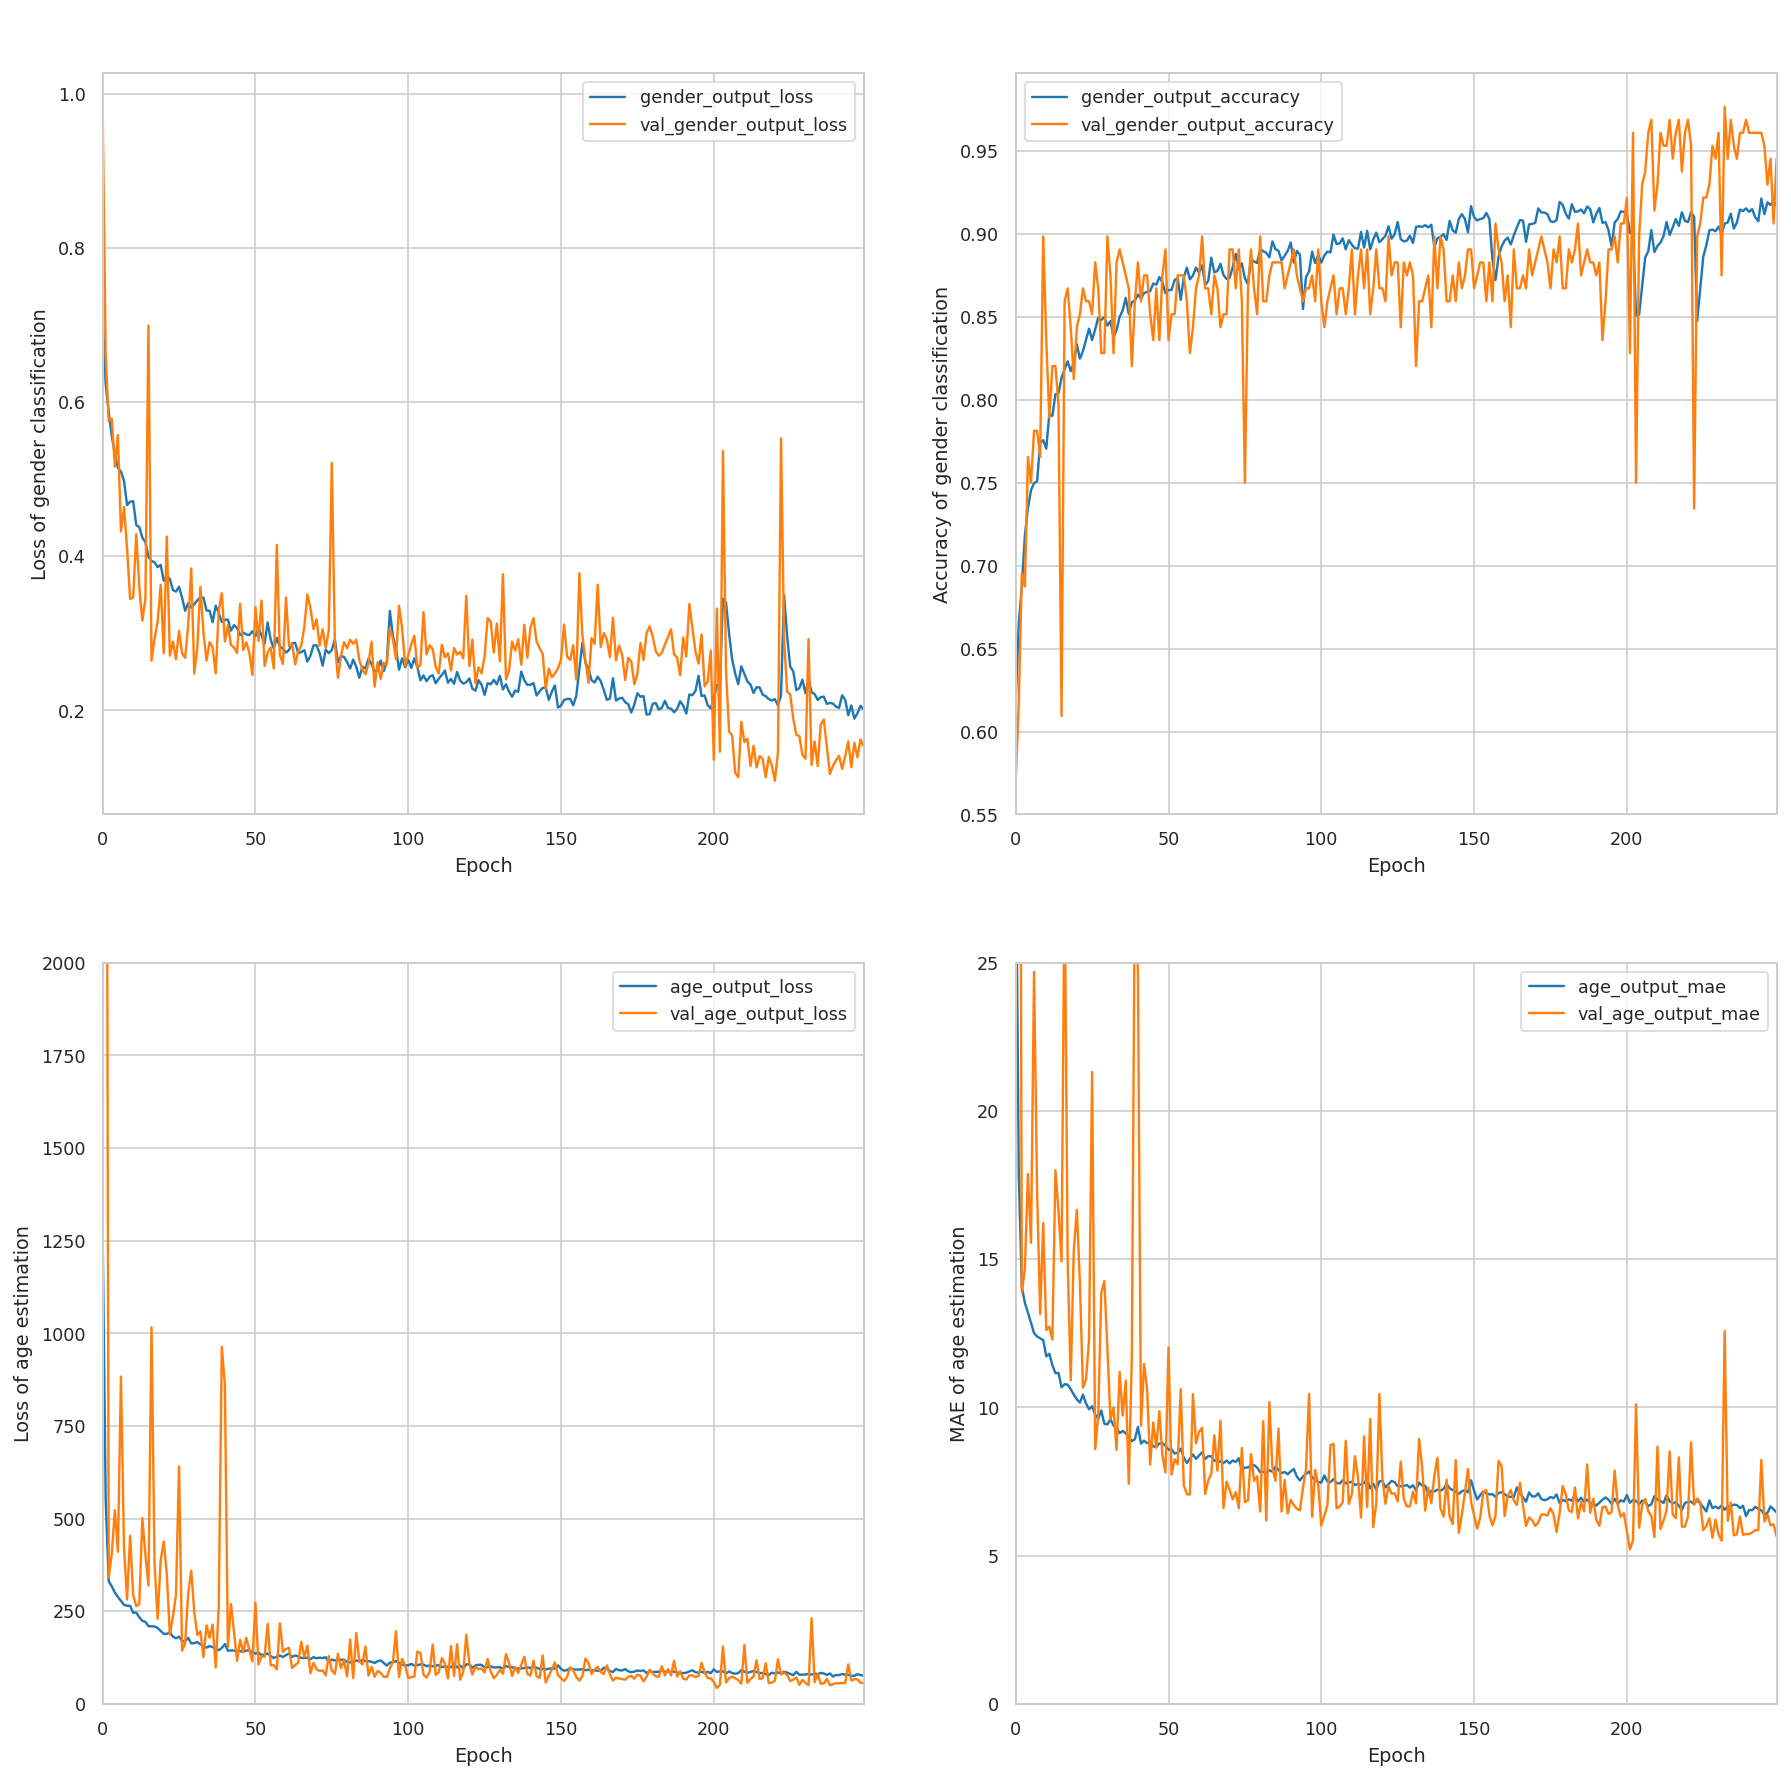

In [ ]:
df_history = pd.DataFrame(history.history)

# 2x2 Plot
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

epochs = df_history.index
titles = \
  iter(['Loss of gender classification',
        'Accuracy of gender classification',
        'Loss of age estimation',
        'MAE of age estimation'])
y_labels = iter(['gender_output_loss', 'val_gender_output_loss',
                 'gender_output_accuracy', 'val_gender_output_accuracy',
                 'age_output_loss', 'val_age_output_loss', 
                 'age_output_mae', 'val_age_output_mae'])

for i in range(2):
  for j in range(2):
    y_1, y_2 = next(y_labels), next(y_labels)
    sns.lineplot(ax=ax[i,j], x=epochs, y=y_1, data=df_history)
    sns.lineplot(ax=ax[i,j], x=epochs, y=y_2, data=df_history)
    ax[i,j].legend([y_1, y_2])
    ax[i,j].set_ylabel(next(titles))
    ax[i,j].set_xlabel('Epoch')
    ax[i,j].margins(x=0)
    if (i==1) and (j==0):
      ax[i,j].set_ylim([0,2000])
    if (i==1) and (j==1):
      ax[i,j].set_ylim([0,25])
      ax[i,j].annotate(f"Best MAE: {df_history['val_age_output_mae'].iloc[-1]:.2f} years", (list(df_history.index)[-1]/2, df_history['val_age_output_mae'].iloc[-1]*10))
df_history.tail()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


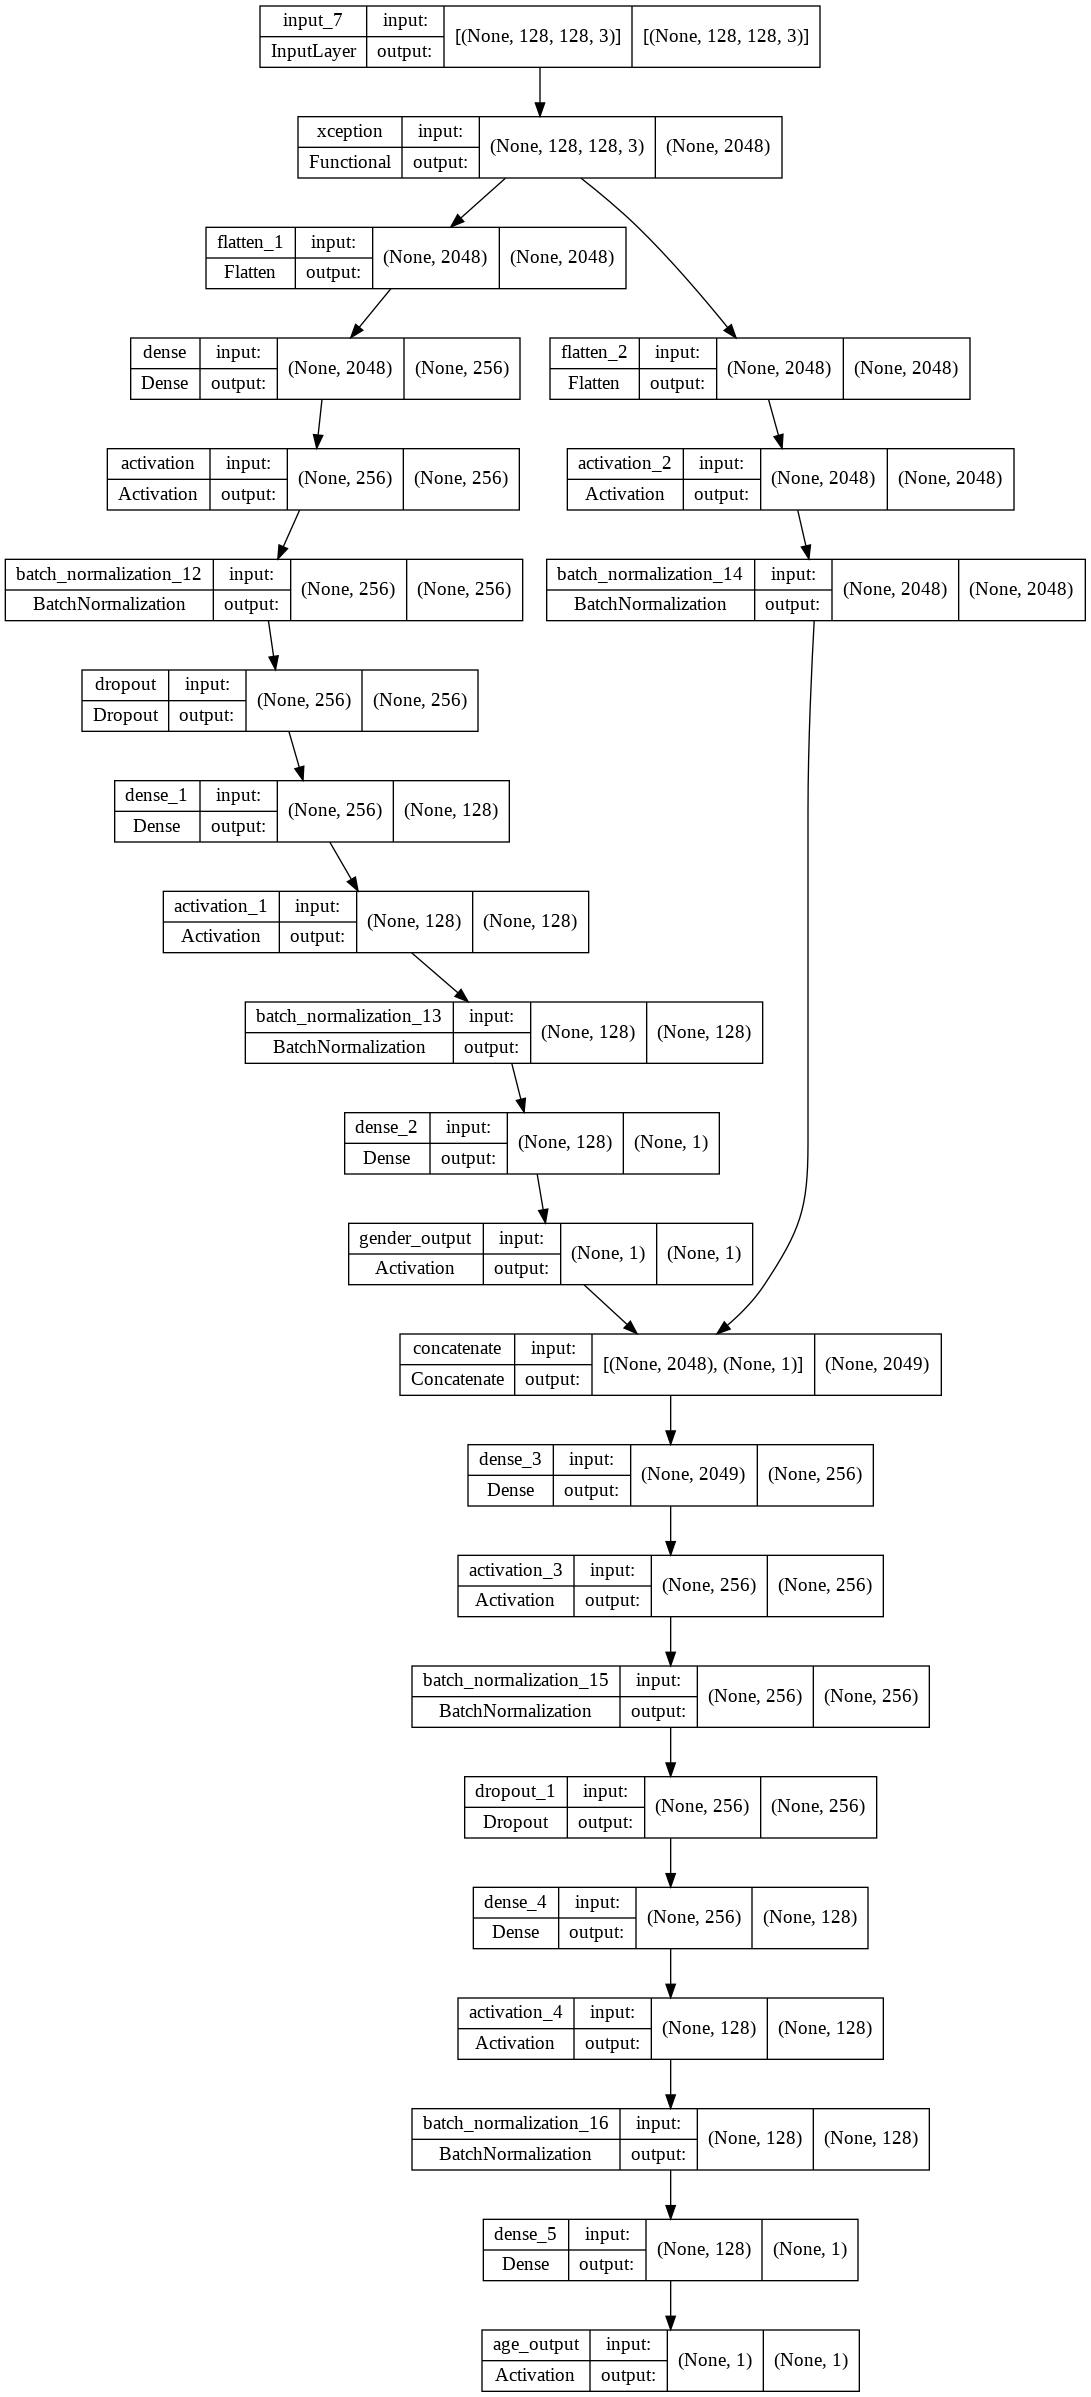

In [ ]:

from keras.layers import GlobalAveragePooling2D
class MultiOutputModel2():
    def base_model(self, inputs):
        base_mod = keras.applications.Xception(
        weights='imagenet',
        input_shape=(128, 128, 3),
        include_top=False)
        # Freeze base model
        for i in range (0, len(base_mod.layers)):
          base_mod.layers[i].trainable = False
        return base_mod(inputs)
        
    def build_gender_branch(self, inputs):
        x = GlobalAveragePooling2D()(inputs)
        x = Flatten()(inputs)

        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dropout(0.1)(x)

        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        
        x = Dense(1)(x)
        x = Activation("sigmoid", name="gender_output")(x)
        return x
    def build_age_branch(self, inputs, gender_branch):   
        x = GlobalAveragePooling2D()(inputs)
        x = Flatten()(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = concatenate([x, gender_branch])
        x = Dense(256)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dropout(0.1)(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)
        return x
    def assemble_full_model(self):
        """
        Used to assemble our multi-output model CNN.
        """
        inputs = Input(shape=(128,128,3))
        # Pre-trained Xception weights require that input be scaled
        # from (0, 255) to a range of (-1., +1.), the rescaling layer
        # outputs: `(inputs * scale) + offset`
        # If already recscaled to 1/255, scale is 2 to convert to 1/127.5 - 1
        scale_layer = keras.layers.Rescaling(scale=2, offset=-1)
        inputs = scale_layer(inputs)

        input = self.base_model(inputs)
        gender_branch = self.build_gender_branch(input)
        age_branch = self.build_age_branch(input, gender_branch)
        model = Model(inputs=inputs,
                     outputs = [age_branch, gender_branch],
                     name="face_net2")
        return model

modelB = MultiOutputModel2().assemble_full_model()

from keras.utils.vis_utils import plot_model

plot_model(modelB, to_file='/content/drive/My Drive/model_plot2.png', show_shapes=True, show_layer_names=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [ ]:

initial_learning_rate = 0.008
epochs = 150

modelB = MultiOutputModel2().assemble_full_model()

modelB.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=initial_learning_rate,
    amsgrad=True, epsilon=0.1
    ), 
    loss={
        'age_output': 'mse', 
        'gender_output': 'binary_crossentropy'},
    loss_weights={
        'age_output': 1.,
        'gender_output': 150.},
    metrics={
        'age_output': 'mae',
        'gender_output': 'accuracy'}
)



callbacks = [
    ModelCheckpoint("/content/drive/My Drive/model_checkpoint", monitor='val_loss'),
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    tf.keras.callbacks.BackupAndRestore('/content/drive/My Drive/backup_final_pre')
]

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = modelB.fit(
    train_generator, 
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs, 
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=callbacks
)

with open('/content/drive/My Drive/trainHistoryDict_B', 'wb') as file_:
        pickle.dump(history.history, file_)


modelB.save("/content/drive/My Drive/age_gender_B.h5")


Epoch 1/150
35/35 [==============================] - ETA: 0s - loss: 1179.5209 - age_output_loss: 1109.4215 - gender_output_loss: 0.4673 - age_output_mae: 29.9531 - gender_output_accuracy: 0.7868INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 91s 1s/step - loss: 1179.5209 - age_output_loss: 1109.4215 - gender_output_loss: 0.4673 - age_output_mae: 29.9531 - gender_output_accuracy: 0.7868 - val_loss: 981.9291 - val_age_output_loss: 927.9198 - val_gender_output_loss: 0.3601 - val_age_output_mae: 27.0219 - val_gender_output_accuracy: 0.8906
Epoch 2/150
35/35 [==============================] - ETA: 0s - loss: 388.3849 - age_output_loss: 333.4650 - gender_output_loss: 0.3661 - age_output_mae: 14.3321 - gender_output_accuracy: 0.8317INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 388.3849 - age_output_loss: 333.4650 - gender_output_loss: 0.3661 - age_output_mae: 14.3321 - gender_output_accuracy: 0.8317 - val_loss: 276.2046 - val_age_output_loss: 225.0432 - val_gender_output_loss: 0.3411 - val_age_output_mae: 11.2572 - val_gender_output_accuracy: 0.8438
Epoch 3/150
35/35 [==============================] - ETA: 0s - loss: 195.1035 - age_output_loss: 141.9728 - gender_output_loss: 0.3542 - age_output_mae: 8.9565 - gender_output_accuracy: 0.8410INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 195.1035 - age_output_loss: 141.9728 - gender_output_loss: 0.3542 - age_output_mae: 8.9565 - gender_output_accuracy: 0.8410 - val_loss: 229.0341 - val_age_output_loss: 180.1368 - val_gender_output_loss: 0.3260 - val_age_output_mae: 10.2113 - val_gender_output_accuracy: 0.8438
Epoch 4/150
35/35 [==============================] - ETA: 0s - loss: 176.5724 - age_output_loss: 126.2803 - gender_output_loss: 0.3353 - age_output_mae: 8.2550 - gender_output_accuracy: 0.8509INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 176.5724 - age_output_loss: 126.2803 - gender_output_loss: 0.3353 - age_output_mae: 8.2550 - gender_output_accuracy: 0.8509 - val_loss: 208.2101 - val_age_output_loss: 149.1383 - val_gender_output_loss: 0.3938 - val_age_output_mae: 9.2544 - val_gender_output_accuracy: 0.8281
Epoch 5/150
35/35 [==============================] - ETA: 0s - loss: 167.4217 - age_output_loss: 117.9329 - gender_output_loss: 0.3299 - age_output_mae: 7.9599 - gender_output_accuracy: 0.8567INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 167.4217 - age_output_loss: 117.9329 - gender_output_loss: 0.3299 - age_output_mae: 7.9599 - gender_output_accuracy: 0.8567 - val_loss: 206.9995 - val_age_output_loss: 156.5346 - val_gender_output_loss: 0.3364 - val_age_output_mae: 9.4584 - val_gender_output_accuracy: 0.8750
Epoch 6/150
35/35 [==============================] - ETA: 0s - loss: 156.6292 - age_output_loss: 110.4017 - gender_output_loss: 0.3082 - age_output_mae: 7.6978 - gender_output_accuracy: 0.8612INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 156.6292 - age_output_loss: 110.4017 - gender_output_loss: 0.3082 - age_output_mae: 7.6978 - gender_output_accuracy: 0.8612 - val_loss: 215.9595 - val_age_output_loss: 160.9418 - val_gender_output_loss: 0.3668 - val_age_output_mae: 9.5273 - val_gender_output_accuracy: 0.8672
Epoch 7/150
35/35 [==============================] - ETA: 0s - loss: 149.3593 - age_output_loss: 101.3304 - gender_output_loss: 0.3202 - age_output_mae: 7.4043 - gender_output_accuracy: 0.8564INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 149.3593 - age_output_loss: 101.3304 - gender_output_loss: 0.3202 - age_output_mae: 7.4043 - gender_output_accuracy: 0.8564 - val_loss: 209.8943 - val_age_output_loss: 155.5199 - val_gender_output_loss: 0.3625 - val_age_output_mae: 9.0964 - val_gender_output_accuracy: 0.8672
Epoch 8/150
35/35 [==============================] - ETA: 0s - loss: 140.3447 - age_output_loss: 96.7460 - gender_output_loss: 0.2907 - age_output_mae: 7.2420 - gender_output_accuracy: 0.8790INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 140.3447 - age_output_loss: 96.7460 - gender_output_loss: 0.2907 - age_output_mae: 7.2420 - gender_output_accuracy: 0.8790 - val_loss: 206.8858 - val_age_output_loss: 145.6403 - val_gender_output_loss: 0.4083 - val_age_output_mae: 9.0177 - val_gender_output_accuracy: 0.8438
Epoch 9/150
35/35 [==============================] - ETA: 0s - loss: 139.8297 - age_output_loss: 94.4462 - gender_output_loss: 0.3026 - age_output_mae: 7.0983 - gender_output_accuracy: 0.8678INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 139.8297 - age_output_loss: 94.4462 - gender_output_loss: 0.3026 - age_output_mae: 7.0983 - gender_output_accuracy: 0.8678 - val_loss: 241.0182 - val_age_output_loss: 143.0056 - val_gender_output_loss: 0.6534 - val_age_output_mae: 9.0258 - val_gender_output_accuracy: 0.8047
Epoch 10/150
35/35 [==============================] - ETA: 0s - loss: 127.1707 - age_output_loss: 83.8874 - gender_output_loss: 0.2886 - age_output_mae: 6.7081 - gender_output_accuracy: 0.8781INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 127.1707 - age_output_loss: 83.8874 - gender_output_loss: 0.2886 - age_output_mae: 6.7081 - gender_output_accuracy: 0.8781 - val_loss: 223.0170 - val_age_output_loss: 148.1390 - val_gender_output_loss: 0.4992 - val_age_output_mae: 9.1361 - val_gender_output_accuracy: 0.8047
Epoch 11/150
35/35 [==============================] - ETA: 0s - loss: 120.3667 - age_output_loss: 80.0999 - gender_output_loss: 0.2684 - age_output_mae: 6.5548 - gender_output_accuracy: 0.8817INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 120.3667 - age_output_loss: 80.0999 - gender_output_loss: 0.2684 - age_output_mae: 6.5548 - gender_output_accuracy: 0.8817 - val_loss: 201.7494 - val_age_output_loss: 138.3911 - val_gender_output_loss: 0.4224 - val_age_output_mae: 8.4755 - val_gender_output_accuracy: 0.8438
Epoch 12/150
35/35 [==============================] - ETA: 0s - loss: 118.5976 - age_output_loss: 77.2524 - gender_output_loss: 0.2756 - age_output_mae: 6.4509 - gender_output_accuracy: 0.8783INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 118.5976 - age_output_loss: 77.2524 - gender_output_loss: 0.2756 - age_output_mae: 6.4509 - gender_output_accuracy: 0.8783 - val_loss: 206.8759 - val_age_output_loss: 142.1563 - val_gender_output_loss: 0.4315 - val_age_output_mae: 8.8247 - val_gender_output_accuracy: 0.8516
Epoch 13/150
35/35 [==============================] - ETA: 0s - loss: 111.9354 - age_output_loss: 72.8262 - gender_output_loss: 0.2607 - age_output_mae: 6.2436 - gender_output_accuracy: 0.8856INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 111.9354 - age_output_loss: 72.8262 - gender_output_loss: 0.2607 - age_output_mae: 6.2436 - gender_output_accuracy: 0.8856 - val_loss: 205.4195 - val_age_output_loss: 149.3045 - val_gender_output_loss: 0.3741 - val_age_output_mae: 9.0296 - val_gender_output_accuracy: 0.8750
Epoch 14/150
35/35 [==============================] - ETA: 0s - loss: 108.9563 - age_output_loss: 70.3263 - gender_output_loss: 0.2575 - age_output_mae: 6.1720 - gender_output_accuracy: 0.8911INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 108.9563 - age_output_loss: 70.3263 - gender_output_loss: 0.2575 - age_output_mae: 6.1720 - gender_output_accuracy: 0.8911 - val_loss: 227.1563 - val_age_output_loss: 138.8811 - val_gender_output_loss: 0.5885 - val_age_output_mae: 8.4130 - val_gender_output_accuracy: 0.8203
Epoch 15/150
35/35 [==============================] - ETA: 0s - loss: 106.7040 - age_output_loss: 67.5805 - gender_output_loss: 0.2608 - age_output_mae: 6.0326 - gender_output_accuracy: 0.8891INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 106.7040 - age_output_loss: 67.5805 - gender_output_loss: 0.2608 - age_output_mae: 6.0326 - gender_output_accuracy: 0.8891 - val_loss: 198.3502 - val_age_output_loss: 137.2556 - val_gender_output_loss: 0.4073 - val_age_output_mae: 8.7352 - val_gender_output_accuracy: 0.8594
Epoch 16/150
35/35 [==============================] - ETA: 0s - loss: 98.2062 - age_output_loss: 59.4966 - gender_output_loss: 0.2581 - age_output_mae: 5.6305 - gender_output_accuracy: 0.8893INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 98.2062 - age_output_loss: 59.4966 - gender_output_loss: 0.2581 - age_output_mae: 5.6305 - gender_output_accuracy: 0.8893 - val_loss: 228.5656 - val_age_output_loss: 134.1695 - val_gender_output_loss: 0.6293 - val_age_output_mae: 8.7894 - val_gender_output_accuracy: 0.7734
Epoch 17/150
35/35 [==============================] - ETA: 0s - loss: 91.8292 - age_output_loss: 56.9887 - gender_output_loss: 0.2323 - age_output_mae: 5.5331 - gender_output_accuracy: 0.8991INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 91.8292 - age_output_loss: 56.9887 - gender_output_loss: 0.2323 - age_output_mae: 5.5331 - gender_output_accuracy: 0.8991 - val_loss: 217.4179 - val_age_output_loss: 134.8163 - val_gender_output_loss: 0.5507 - val_age_output_mae: 8.7855 - val_gender_output_accuracy: 0.8281
Epoch 18/150
35/35 [==============================] - ETA: 0s - loss: 94.5397 - age_output_loss: 58.8621 - gender_output_loss: 0.2379 - age_output_mae: 5.6230 - gender_output_accuracy: 0.8973INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 42s 1s/step - loss: 94.5397 - age_output_loss: 58.8621 - gender_output_loss: 0.2379 - age_output_mae: 5.6230 - gender_output_accuracy: 0.8973 - val_loss: 211.2482 - val_age_output_loss: 139.0941 - val_gender_output_loss: 0.4810 - val_age_output_mae: 8.9737 - val_gender_output_accuracy: 0.8281
Epoch 19/150
35/35 [==============================] - ETA: 0s - loss: 92.1435 - age_output_loss: 56.6264 - gender_output_loss: 0.2368 - age_output_mae: 5.5709 - gender_output_accuracy: 0.8987INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 92.1435 - age_output_loss: 56.6264 - gender_output_loss: 0.2368 - age_output_mae: 5.5709 - gender_output_accuracy: 0.8987 - val_loss: 211.7977 - val_age_output_loss: 152.1964 - val_gender_output_loss: 0.3973 - val_age_output_mae: 8.9524 - val_gender_output_accuracy: 0.8359
Epoch 20/150
35/35 [==============================] - ETA: 0s - loss: 91.6193 - age_output_loss: 55.3857 - gender_output_loss: 0.2416 - age_output_mae: 5.4451 - gender_output_accuracy: 0.8959INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 91.6193 - age_output_loss: 55.3857 - gender_output_loss: 0.2416 - age_output_mae: 5.4451 - gender_output_accuracy: 0.8959 - val_loss: 202.5245 - val_age_output_loss: 136.3485 - val_gender_output_loss: 0.4412 - val_age_output_mae: 8.6607 - val_gender_output_accuracy: 0.8359
Epoch 21/150
35/35 [==============================] - ETA: 0s - loss: 84.3661 - age_output_loss: 52.1970 - gender_output_loss: 0.2145 - age_output_mae: 5.2843 - gender_output_accuracy: 0.9081INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 84.3661 - age_output_loss: 52.1970 - gender_output_loss: 0.2145 - age_output_mae: 5.2843 - gender_output_accuracy: 0.9081 - val_loss: 204.7000 - val_age_output_loss: 141.7945 - val_gender_output_loss: 0.4194 - val_age_output_mae: 8.9570 - val_gender_output_accuracy: 0.8594
Epoch 22/150
35/35 [==============================] - ETA: 0s - loss: 79.4866 - age_output_loss: 50.2706 - gender_output_loss: 0.1948 - age_output_mae: 5.2120 - gender_output_accuracy: 0.9202INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 49s 1s/step - loss: 79.4866 - age_output_loss: 50.2706 - gender_output_loss: 0.1948 - age_output_mae: 5.2120 - gender_output_accuracy: 0.9202 - val_loss: 226.6606 - val_age_output_loss: 168.9144 - val_gender_output_loss: 0.3850 - val_age_output_mae: 9.7544 - val_gender_output_accuracy: 0.8828
Epoch 23/150
35/35 [==============================] - ETA: 0s - loss: 83.5935 - age_output_loss: 52.7973 - gender_output_loss: 0.2053 - age_output_mae: 5.3234 - gender_output_accuracy: 0.9138INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 83.5935 - age_output_loss: 52.7973 - gender_output_loss: 0.2053 - age_output_mae: 5.3234 - gender_output_accuracy: 0.9138 - val_loss: 225.2950 - val_age_output_loss: 150.2267 - val_gender_output_loss: 0.5005 - val_age_output_mae: 9.4306 - val_gender_output_accuracy: 0.8672
Epoch 24/150
35/35 [==============================] - ETA: 0s - loss: 81.7688 - age_output_loss: 51.3437 - gender_output_loss: 0.2028 - age_output_mae: 5.2582 - gender_output_accuracy: 0.9163INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 81.7688 - age_output_loss: 51.3437 - gender_output_loss: 0.2028 - age_output_mae: 5.2582 - gender_output_accuracy: 0.9163 - val_loss: 199.9937 - val_age_output_loss: 123.8711 - val_gender_output_loss: 0.5075 - val_age_output_mae: 8.6703 - val_gender_output_accuracy: 0.8359
Epoch 25/150
35/35 [==============================] - ETA: 0s - loss: 76.7015 - age_output_loss: 47.1184 - gender_output_loss: 0.1972 - age_output_mae: 5.0384 - gender_output_accuracy: 0.9227INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 42s 1s/step - loss: 76.7015 - age_output_loss: 47.1184 - gender_output_loss: 0.1972 - age_output_mae: 5.0384 - gender_output_accuracy: 0.9227 - val_loss: 206.1401 - val_age_output_loss: 133.7442 - val_gender_output_loss: 0.4826 - val_age_output_mae: 8.5527 - val_gender_output_accuracy: 0.8828
Epoch 26/150
35/35 [==============================] - ETA: 0s - loss: 75.9225 - age_output_loss: 45.7800 - gender_output_loss: 0.2010 - age_output_mae: 4.9513 - gender_output_accuracy: 0.9142INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 42s 1s/step - loss: 75.9225 - age_output_loss: 45.7800 - gender_output_loss: 0.2010 - age_output_mae: 4.9513 - gender_output_accuracy: 0.9142 - val_loss: 213.0695 - val_age_output_loss: 128.6778 - val_gender_output_loss: 0.5626 - val_age_output_mae: 8.8189 - val_gender_output_accuracy: 0.8359
Epoch 27/150
35/35 [==============================] - ETA: 0s - loss: 67.9314 - age_output_loss: 41.2047 - gender_output_loss: 0.1782 - age_output_mae: 4.7165 - gender_output_accuracy: 0.9275INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 67.9314 - age_output_loss: 41.2047 - gender_output_loss: 0.1782 - age_output_mae: 4.7165 - gender_output_accuracy: 0.9275 - val_loss: 205.3983 - val_age_output_loss: 138.9100 - val_gender_output_loss: 0.4433 - val_age_output_mae: 9.0124 - val_gender_output_accuracy: 0.8672
Epoch 28/150
35/35 [==============================] - ETA: 0s - loss: 73.0991 - age_output_loss: 44.8086 - gender_output_loss: 0.1886 - age_output_mae: 4.8582 - gender_output_accuracy: 0.9179INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 73.0991 - age_output_loss: 44.8086 - gender_output_loss: 0.1886 - age_output_mae: 4.8582 - gender_output_accuracy: 0.9179 - val_loss: 212.5244 - val_age_output_loss: 140.2398 - val_gender_output_loss: 0.4819 - val_age_output_mae: 8.7174 - val_gender_output_accuracy: 0.8516
Epoch 29/150
35/35 [==============================] - ETA: 0s - loss: 67.3471 - age_output_loss: 40.8816 - gender_output_loss: 0.1764 - age_output_mae: 4.6682 - gender_output_accuracy: 0.9236INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 67.3471 - age_output_loss: 40.8816 - gender_output_loss: 0.1764 - age_output_mae: 4.6682 - gender_output_accuracy: 0.9236 - val_loss: 225.9366 - val_age_output_loss: 160.3715 - val_gender_output_loss: 0.4371 - val_age_output_mae: 9.6179 - val_gender_output_accuracy: 0.8828
Epoch 30/150
35/35 [==============================] - ETA: 0s - loss: 65.1360 - age_output_loss: 39.8404 - gender_output_loss: 0.1686 - age_output_mae: 4.6385 - gender_output_accuracy: 0.9268INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 65.1360 - age_output_loss: 39.8404 - gender_output_loss: 0.1686 - age_output_mae: 4.6385 - gender_output_accuracy: 0.9268 - val_loss: 227.1661 - val_age_output_loss: 151.7416 - val_gender_output_loss: 0.5028 - val_age_output_mae: 9.3062 - val_gender_output_accuracy: 0.8594
Epoch 31/150
35/35 [==============================] - ETA: 0s - loss: 64.6369 - age_output_loss: 37.3283 - gender_output_loss: 0.1821 - age_output_mae: 4.4674 - gender_output_accuracy: 0.9268INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 42s 1s/step - loss: 64.6369 - age_output_loss: 37.3283 - gender_output_loss: 0.1821 - age_output_mae: 4.4674 - gender_output_accuracy: 0.9268 - val_loss: 213.7384 - val_age_output_loss: 137.5553 - val_gender_output_loss: 0.5079 - val_age_output_mae: 8.6903 - val_gender_output_accuracy: 0.8516
Epoch 32/150
35/35 [==============================] - ETA: 0s - loss: 65.4821 - age_output_loss: 38.9840 - gender_output_loss: 0.1767 - age_output_mae: 4.5463 - gender_output_accuracy: 0.9298INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 65.4821 - age_output_loss: 38.9840 - gender_output_loss: 0.1767 - age_output_mae: 4.5463 - gender_output_accuracy: 0.9298 - val_loss: 233.4912 - val_age_output_loss: 136.1441 - val_gender_output_loss: 0.6490 - val_age_output_mae: 8.6605 - val_gender_output_accuracy: 0.8359
Epoch 33/150
35/35 [==============================] - ETA: 0s - loss: 63.6158 - age_output_loss: 38.1222 - gender_output_loss: 0.1700 - age_output_mae: 4.5322 - gender_output_accuracy: 0.9309INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 63.6158 - age_output_loss: 38.1222 - gender_output_loss: 0.1700 - age_output_mae: 4.5322 - gender_output_accuracy: 0.9309 - val_loss: 222.2766 - val_age_output_loss: 133.1944 - val_gender_output_loss: 0.5939 - val_age_output_mae: 8.4957 - val_gender_output_accuracy: 0.7969
Epoch 34/150
35/35 [==============================] - ETA: 0s - loss: 59.9800 - age_output_loss: 36.1919 - gender_output_loss: 0.1586 - age_output_mae: 4.4701 - gender_output_accuracy: 0.9346INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 59.9800 - age_output_loss: 36.1919 - gender_output_loss: 0.1586 - age_output_mae: 4.4701 - gender_output_accuracy: 0.9346 - val_loss: 212.7408 - val_age_output_loss: 141.5257 - val_gender_output_loss: 0.4748 - val_age_output_mae: 8.8260 - val_gender_output_accuracy: 0.8750
Epoch 35/150
35/35 [==============================] - ETA: 0s - loss: 61.8829 - age_output_loss: 36.4199 - gender_output_loss: 0.1698 - age_output_mae: 4.4084 - gender_output_accuracy: 0.9270INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 41s 1s/step - loss: 61.8829 - age_output_loss: 36.4199 - gender_output_loss: 0.1698 - age_output_mae: 4.4084 - gender_output_accuracy: 0.9270 - val_loss: 290.7915 - val_age_output_loss: 138.0382 - val_gender_output_loss: 1.0184 - val_age_output_mae: 8.9228 - val_gender_output_accuracy: 0.8281
Epoch 36/150
35/35 [==============================] - ETA: 0s - loss: 58.4313 - age_output_loss: 34.9490 - gender_output_loss: 0.1565 - age_output_mae: 4.3046 - gender_output_accuracy: 0.9355INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 58.4313 - age_output_loss: 34.9490 - gender_output_loss: 0.1565 - age_output_mae: 4.3046 - gender_output_accuracy: 0.9355 - val_loss: 267.7205 - val_age_output_loss: 130.8957 - val_gender_output_loss: 0.9122 - val_age_output_mae: 8.6875 - val_gender_output_accuracy: 0.8359
Epoch 37/150
35/35 [==============================] - ETA: 0s - loss: 59.8110 - age_output_loss: 36.4092 - gender_output_loss: 0.1560 - age_output_mae: 4.3937 - gender_output_accuracy: 0.9376INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 59.8110 - age_output_loss: 36.4092 - gender_output_loss: 0.1560 - age_output_mae: 4.3937 - gender_output_accuracy: 0.9376 - val_loss: 228.3041 - val_age_output_loss: 134.4945 - val_gender_output_loss: 0.6254 - val_age_output_mae: 9.0912 - val_gender_output_accuracy: 0.8516
Epoch 38/150
35/35 [==============================] - ETA: 0s - loss: 57.9042 - age_output_loss: 35.1873 - gender_output_loss: 0.1514 - age_output_mae: 4.3161 - gender_output_accuracy: 0.9394INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 57.9042 - age_output_loss: 35.1873 - gender_output_loss: 0.1514 - age_output_mae: 4.3161 - gender_output_accuracy: 0.9394 - val_loss: 210.9669 - val_age_output_loss: 136.1807 - val_gender_output_loss: 0.4986 - val_age_output_mae: 8.6690 - val_gender_output_accuracy: 0.8594
Epoch 39/150
35/35 [==============================] - ETA: 0s - loss: 53.2161 - age_output_loss: 33.2361 - gender_output_loss: 0.1332 - age_output_mae: 4.2526 - gender_output_accuracy: 0.9453INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 53.2161 - age_output_loss: 33.2361 - gender_output_loss: 0.1332 - age_output_mae: 4.2526 - gender_output_accuracy: 0.9453 - val_loss: 228.5239 - val_age_output_loss: 142.2519 - val_gender_output_loss: 0.5751 - val_age_output_mae: 9.1831 - val_gender_output_accuracy: 0.8672
Epoch 40/150
35/35 [==============================] - ETA: 0s - loss: 54.8924 - age_output_loss: 33.4356 - gender_output_loss: 0.1430 - age_output_mae: 4.2052 - gender_output_accuracy: 0.9460INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 54.8924 - age_output_loss: 33.4356 - gender_output_loss: 0.1430 - age_output_mae: 4.2052 - gender_output_accuracy: 0.9460 - val_loss: 215.1987 - val_age_output_loss: 126.2654 - val_gender_output_loss: 0.5929 - val_age_output_mae: 8.3578 - val_gender_output_accuracy: 0.8438
Epoch 41/150
35/35 [==============================] - ETA: 0s - loss: 52.1900 - age_output_loss: 31.9782 - gender_output_loss: 0.1347 - age_output_mae: 4.1660 - gender_output_accuracy: 0.9435INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 42s 1s/step - loss: 52.1900 - age_output_loss: 31.9782 - gender_output_loss: 0.1347 - age_output_mae: 4.1660 - gender_output_accuracy: 0.9435 - val_loss: 238.7742 - val_age_output_loss: 137.6263 - val_gender_output_loss: 0.6743 - val_age_output_mae: 8.9601 - val_gender_output_accuracy: 0.8516
Epoch 42/150
35/35 [==============================] - ETA: 0s - loss: 48.9105 - age_output_loss: 29.6943 - gender_output_loss: 0.1281 - age_output_mae: 4.0098 - gender_output_accuracy: 0.9449INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 48.9105 - age_output_loss: 29.6943 - gender_output_loss: 0.1281 - age_output_mae: 4.0098 - gender_output_accuracy: 0.9449 - val_loss: 206.4057 - val_age_output_loss: 123.4722 - val_gender_output_loss: 0.5529 - val_age_output_mae: 8.4310 - val_gender_output_accuracy: 0.8828
Epoch 43/150
35/35 [==============================] - ETA: 0s - loss: 54.2085 - age_output_loss: 30.1017 - gender_output_loss: 0.1607 - age_output_mae: 4.0161 - gender_output_accuracy: 0.9387INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 54.2085 - age_output_loss: 30.1017 - gender_output_loss: 0.1607 - age_output_mae: 4.0161 - gender_output_accuracy: 0.9387 - val_loss: 243.2227 - val_age_output_loss: 130.1121 - val_gender_output_loss: 0.7541 - val_age_output_mae: 8.9334 - val_gender_output_accuracy: 0.8125
Epoch 44/150
35/35 [==============================] - ETA: 0s - loss: 55.3223 - age_output_loss: 31.5384 - gender_output_loss: 0.1586 - age_output_mae: 4.1410 - gender_output_accuracy: 0.9385INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 55.3223 - age_output_loss: 31.5384 - gender_output_loss: 0.1586 - age_output_mae: 4.1410 - gender_output_accuracy: 0.9385 - val_loss: 204.0143 - val_age_output_loss: 125.6919 - val_gender_output_loss: 0.5221 - val_age_output_mae: 8.4842 - val_gender_output_accuracy: 0.8750
Epoch 45/150
35/35 [==============================] - ETA: 0s - loss: 49.2549 - age_output_loss: 27.7472 - gender_output_loss: 0.1434 - age_output_mae: 3.8676 - gender_output_accuracy: 0.9398INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 49.2549 - age_output_loss: 27.7472 - gender_output_loss: 0.1434 - age_output_mae: 3.8676 - gender_output_accuracy: 0.9398 - val_loss: 237.6017 - val_age_output_loss: 135.7967 - val_gender_output_loss: 0.6787 - val_age_output_mae: 8.7081 - val_gender_output_accuracy: 0.8516
Epoch 46/150
35/35 [==============================] - ETA: 0s - loss: 48.7990 - age_output_loss: 30.0979 - gender_output_loss: 0.1247 - age_output_mae: 3.9548 - gender_output_accuracy: 0.9511INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 48.7990 - age_output_loss: 30.0979 - gender_output_loss: 0.1247 - age_output_mae: 3.9548 - gender_output_accuracy: 0.9511 - val_loss: 256.1407 - val_age_output_loss: 131.1730 - val_gender_output_loss: 0.8331 - val_age_output_mae: 8.6731 - val_gender_output_accuracy: 0.8438
Epoch 47/150
35/35 [==============================] - ETA: 0s - loss: 45.4865 - age_output_loss: 27.4963 - gender_output_loss: 0.1199 - age_output_mae: 3.8735 - gender_output_accuracy: 0.9524INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 45.4865 - age_output_loss: 27.4963 - gender_output_loss: 0.1199 - age_output_mae: 3.8735 - gender_output_accuracy: 0.9524 - val_loss: 215.0424 - val_age_output_loss: 124.0638 - val_gender_output_loss: 0.6065 - val_age_output_mae: 8.4719 - val_gender_output_accuracy: 0.8750
Epoch 48/150
35/35 [==============================] - ETA: 0s - loss: 46.8293 - age_output_loss: 28.9610 - gender_output_loss: 0.1191 - age_output_mae: 3.9829 - gender_output_accuracy: 0.9522INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 46.8293 - age_output_loss: 28.9610 - gender_output_loss: 0.1191 - age_output_mae: 3.9829 - gender_output_accuracy: 0.9522 - val_loss: 236.0307 - val_age_output_loss: 122.9973 - val_gender_output_loss: 0.7536 - val_age_output_mae: 8.5178 - val_gender_output_accuracy: 0.8594
Epoch 49/150
35/35 [==============================] - ETA: 0s - loss: 45.5035 - age_output_loss: 27.8708 - gender_output_loss: 0.1176 - age_output_mae: 3.8524 - gender_output_accuracy: 0.9533INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 45.5035 - age_output_loss: 27.8708 - gender_output_loss: 0.1176 - age_output_mae: 3.8524 - gender_output_accuracy: 0.9533 - val_loss: 229.2030 - val_age_output_loss: 136.1203 - val_gender_output_loss: 0.6206 - val_age_output_mae: 8.8968 - val_gender_output_accuracy: 0.8672
Epoch 50/150
35/35 [==============================] - ETA: 0s - loss: 43.3093 - age_output_loss: 26.1303 - gender_output_loss: 0.1145 - age_output_mae: 3.7515 - gender_output_accuracy: 0.9543INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 43.3093 - age_output_loss: 26.1303 - gender_output_loss: 0.1145 - age_output_mae: 3.7515 - gender_output_accuracy: 0.9543 - val_loss: 245.8525 - val_age_output_loss: 133.1173 - val_gender_output_loss: 0.7516 - val_age_output_mae: 8.7398 - val_gender_output_accuracy: 0.8359
Epoch 51/150
35/35 [==============================] - ETA: 0s - loss: 43.7062 - age_output_loss: 25.5084 - gender_output_loss: 0.1213 - age_output_mae: 3.7453 - gender_output_accuracy: 0.9552INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 43.7062 - age_output_loss: 25.5084 - gender_output_loss: 0.1213 - age_output_mae: 3.7453 - gender_output_accuracy: 0.9552 - val_loss: 234.5161 - val_age_output_loss: 135.4011 - val_gender_output_loss: 0.6608 - val_age_output_mae: 8.5200 - val_gender_output_accuracy: 0.8594
Epoch 52/150
35/35 [==============================] - ETA: 0s - loss: 42.9717 - age_output_loss: 26.0264 - gender_output_loss: 0.1130 - age_output_mae: 3.7296 - gender_output_accuracy: 0.9556INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 42.9717 - age_output_loss: 26.0264 - gender_output_loss: 0.1130 - age_output_mae: 3.7296 - gender_output_accuracy: 0.9556 - val_loss: 255.5466 - val_age_output_loss: 135.1728 - val_gender_output_loss: 0.8025 - val_age_output_mae: 8.7467 - val_gender_output_accuracy: 0.8438
Epoch 53/150
35/35 [==============================] - ETA: 0s - loss: 44.0012 - age_output_loss: 26.6999 - gender_output_loss: 0.1153 - age_output_mae: 3.7939 - gender_output_accuracy: 0.9570INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 44.0012 - age_output_loss: 26.6999 - gender_output_loss: 0.1153 - age_output_mae: 3.7939 - gender_output_accuracy: 0.9570 - val_loss: 264.4601 - val_age_output_loss: 132.9697 - val_gender_output_loss: 0.8766 - val_age_output_mae: 8.6553 - val_gender_output_accuracy: 0.8359
Epoch 54/150
35/35 [==============================] - ETA: 0s - loss: 45.4486 - age_output_loss: 27.2953 - gender_output_loss: 0.1210 - age_output_mae: 3.8147 - gender_output_accuracy: 0.9561INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 45.4486 - age_output_loss: 27.2953 - gender_output_loss: 0.1210 - age_output_mae: 3.8147 - gender_output_accuracy: 0.9561 - val_loss: 268.8471 - val_age_output_loss: 136.3272 - val_gender_output_loss: 0.8835 - val_age_output_mae: 8.4623 - val_gender_output_accuracy: 0.7812
Epoch 55/150
35/35 [==============================] - ETA: 0s - loss: 44.2176 - age_output_loss: 27.4185 - gender_output_loss: 0.1120 - age_output_mae: 3.8086 - gender_output_accuracy: 0.9520INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 44.2176 - age_output_loss: 27.4185 - gender_output_loss: 0.1120 - age_output_mae: 3.8086 - gender_output_accuracy: 0.9520 - val_loss: 233.4607 - val_age_output_loss: 143.8363 - val_gender_output_loss: 0.5975 - val_age_output_mae: 8.7537 - val_gender_output_accuracy: 0.8672
Epoch 56/150
35/35 [==============================] - ETA: 0s - loss: 40.8058 - age_output_loss: 26.0879 - gender_output_loss: 0.0981 - age_output_mae: 3.8110 - gender_output_accuracy: 0.9650INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 40.8058 - age_output_loss: 26.0879 - gender_output_loss: 0.0981 - age_output_mae: 3.8110 - gender_output_accuracy: 0.9650 - val_loss: 232.0041 - val_age_output_loss: 124.8047 - val_gender_output_loss: 0.7147 - val_age_output_mae: 8.1922 - val_gender_output_accuracy: 0.8516
Epoch 57/150
35/35 [==============================] - ETA: 0s - loss: 40.2374 - age_output_loss: 24.3725 - gender_output_loss: 0.1058 - age_output_mae: 3.6683 - gender_output_accuracy: 0.9579INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 40.2374 - age_output_loss: 24.3725 - gender_output_loss: 0.1058 - age_output_mae: 3.6683 - gender_output_accuracy: 0.9579 - val_loss: 228.7394 - val_age_output_loss: 129.7702 - val_gender_output_loss: 0.6598 - val_age_output_mae: 8.2940 - val_gender_output_accuracy: 0.8438
Epoch 58/150
35/35 [==============================] - ETA: 0s - loss: 44.0857 - age_output_loss: 26.1795 - gender_output_loss: 0.1194 - age_output_mae: 3.7260 - gender_output_accuracy: 0.9538INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 44.0857 - age_output_loss: 26.1795 - gender_output_loss: 0.1194 - age_output_mae: 3.7260 - gender_output_accuracy: 0.9538 - val_loss: 259.9146 - val_age_output_loss: 131.6921 - val_gender_output_loss: 0.8548 - val_age_output_mae: 8.7874 - val_gender_output_accuracy: 0.8281
Epoch 59/150
35/35 [==============================] - ETA: 0s - loss: 41.6673 - age_output_loss: 23.5376 - gender_output_loss: 0.1209 - age_output_mae: 3.5852 - gender_output_accuracy: 0.9506INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 41.6673 - age_output_loss: 23.5376 - gender_output_loss: 0.1209 - age_output_mae: 3.5852 - gender_output_accuracy: 0.9506 - val_loss: 240.1418 - val_age_output_loss: 133.6396 - val_gender_output_loss: 0.7100 - val_age_output_mae: 8.5212 - val_gender_output_accuracy: 0.8906
Epoch 60/150
35/35 [==============================] - ETA: 0s - loss: 42.2618 - age_output_loss: 24.3837 - gender_output_loss: 0.1192 - age_output_mae: 3.6257 - gender_output_accuracy: 0.9517INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 42.2618 - age_output_loss: 24.3837 - gender_output_loss: 0.1192 - age_output_mae: 3.6257 - gender_output_accuracy: 0.9517 - val_loss: 260.2531 - val_age_output_loss: 132.3922 - val_gender_output_loss: 0.8524 - val_age_output_mae: 8.5315 - val_gender_output_accuracy: 0.8594
Epoch 61/150
35/35 [==============================] - ETA: 0s - loss: 41.5710 - age_output_loss: 25.9251 - gender_output_loss: 0.1043 - age_output_mae: 3.7152 - gender_output_accuracy: 0.9595INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 41.5710 - age_output_loss: 25.9251 - gender_output_loss: 0.1043 - age_output_mae: 3.7152 - gender_output_accuracy: 0.9595 - val_loss: 231.0144 - val_age_output_loss: 130.3434 - val_gender_output_loss: 0.6711 - val_age_output_mae: 8.3673 - val_gender_output_accuracy: 0.8672
Epoch 62/150
35/35 [==============================] - ETA: 0s - loss: 40.7935 - age_output_loss: 24.9278 - gender_output_loss: 0.1058 - age_output_mae: 3.6454 - gender_output_accuracy: 0.9577INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 40.7935 - age_output_loss: 24.9278 - gender_output_loss: 0.1058 - age_output_mae: 3.6454 - gender_output_accuracy: 0.9577 - val_loss: 246.7206 - val_age_output_loss: 130.6332 - val_gender_output_loss: 0.7739 - val_age_output_mae: 8.3266 - val_gender_output_accuracy: 0.8516
Epoch 63/150
35/35 [==============================] - ETA: 0s - loss: 40.1750 - age_output_loss: 24.3103 - gender_output_loss: 0.1058 - age_output_mae: 3.6423 - gender_output_accuracy: 0.9595INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 40.1750 - age_output_loss: 24.3103 - gender_output_loss: 0.1058 - age_output_mae: 3.6423 - gender_output_accuracy: 0.9595 - val_loss: 238.9924 - val_age_output_loss: 136.6383 - val_gender_output_loss: 0.6824 - val_age_output_mae: 8.4401 - val_gender_output_accuracy: 0.8594
Epoch 64/150
35/35 [==============================] - ETA: 0s - loss: 38.4135 - age_output_loss: 24.8848 - gender_output_loss: 0.0902 - age_output_mae: 3.6284 - gender_output_accuracy: 0.9652INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 38.4135 - age_output_loss: 24.8848 - gender_output_loss: 0.0902 - age_output_mae: 3.6284 - gender_output_accuracy: 0.9652 - val_loss: 259.9471 - val_age_output_loss: 144.3374 - val_gender_output_loss: 0.7707 - val_age_output_mae: 8.8483 - val_gender_output_accuracy: 0.8281
Epoch 65/150
35/35 [==============================] - ETA: 0s - loss: 38.4248 - age_output_loss: 22.5844 - gender_output_loss: 0.1056 - age_output_mae: 3.5006 - gender_output_accuracy: 0.9568INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 38.4248 - age_output_loss: 22.5844 - gender_output_loss: 0.1056 - age_output_mae: 3.5006 - gender_output_accuracy: 0.9568 - val_loss: 254.6537 - val_age_output_loss: 137.7684 - val_gender_output_loss: 0.7792 - val_age_output_mae: 8.6875 - val_gender_output_accuracy: 0.8125
Epoch 66/150
35/35 [==============================] - ETA: 0s - loss: 36.5586 - age_output_loss: 22.8524 - gender_output_loss: 0.0914 - age_output_mae: 3.5107 - gender_output_accuracy: 0.9641INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 36.5586 - age_output_loss: 22.8524 - gender_output_loss: 0.0914 - age_output_mae: 3.5107 - gender_output_accuracy: 0.9641 - val_loss: 265.2834 - val_age_output_loss: 137.4322 - val_gender_output_loss: 0.8523 - val_age_output_mae: 8.7177 - val_gender_output_accuracy: 0.8438
Epoch 67/150
35/35 [==============================] - ETA: 0s - loss: 41.1912 - age_output_loss: 22.3034 - gender_output_loss: 0.1259 - age_output_mae: 3.5036 - gender_output_accuracy: 0.9527INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 41.1912 - age_output_loss: 22.3034 - gender_output_loss: 0.1259 - age_output_mae: 3.5036 - gender_output_accuracy: 0.9527 - val_loss: 234.8938 - val_age_output_loss: 135.4169 - val_gender_output_loss: 0.6632 - val_age_output_mae: 8.7407 - val_gender_output_accuracy: 0.8359
Epoch 68/150
35/35 [==============================] - ETA: 0s - loss: 37.6840 - age_output_loss: 21.9044 - gender_output_loss: 0.1052 - age_output_mae: 3.4834 - gender_output_accuracy: 0.9572INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 46s 1s/step - loss: 37.6840 - age_output_loss: 21.9044 - gender_output_loss: 0.1052 - age_output_mae: 3.4834 - gender_output_accuracy: 0.9572 - val_loss: 245.4434 - val_age_output_loss: 139.6952 - val_gender_output_loss: 0.7050 - val_age_output_mae: 8.8110 - val_gender_output_accuracy: 0.8672
Epoch 69/150
35/35 [==============================] - ETA: 0s - loss: 36.0381 - age_output_loss: 21.1055 - gender_output_loss: 0.0996 - age_output_mae: 3.3839 - gender_output_accuracy: 0.9636INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 36.0381 - age_output_loss: 21.1055 - gender_output_loss: 0.0996 - age_output_mae: 3.3839 - gender_output_accuracy: 0.9636 - val_loss: 245.9829 - val_age_output_loss: 130.2777 - val_gender_output_loss: 0.7714 - val_age_output_mae: 8.3497 - val_gender_output_accuracy: 0.8438
Epoch 70/150
35/35 [==============================] - ETA: 0s - loss: 37.9598 - age_output_loss: 22.3433 - gender_output_loss: 0.1041 - age_output_mae: 3.4326 - gender_output_accuracy: 0.9584INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 37.9598 - age_output_loss: 22.3433 - gender_output_loss: 0.1041 - age_output_mae: 3.4326 - gender_output_accuracy: 0.9584 - val_loss: 247.2262 - val_age_output_loss: 134.2805 - val_gender_output_loss: 0.7530 - val_age_output_mae: 8.5984 - val_gender_output_accuracy: 0.8438
Epoch 71/150
35/35 [==============================] - ETA: 0s - loss: 36.2336 - age_output_loss: 21.4388 - gender_output_loss: 0.0986 - age_output_mae: 3.4089 - gender_output_accuracy: 0.9597INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 36.2336 - age_output_loss: 21.4388 - gender_output_loss: 0.0986 - age_output_mae: 3.4089 - gender_output_accuracy: 0.9597 - val_loss: 249.9511 - val_age_output_loss: 138.8744 - val_gender_output_loss: 0.7405 - val_age_output_mae: 8.6645 - val_gender_output_accuracy: 0.8516
Epoch 72/150
35/35 [==============================] - ETA: 0s - loss: 35.1681 - age_output_loss: 21.3990 - gender_output_loss: 0.0918 - age_output_mae: 3.4217 - gender_output_accuracy: 0.9652INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 35.1681 - age_output_loss: 21.3990 - gender_output_loss: 0.0918 - age_output_mae: 3.4217 - gender_output_accuracy: 0.9652 - val_loss: 242.1744 - val_age_output_loss: 141.8151 - val_gender_output_loss: 0.6691 - val_age_output_mae: 8.9659 - val_gender_output_accuracy: 0.8516
Epoch 73/150
35/35 [==============================] - ETA: 0s - loss: 34.8644 - age_output_loss: 21.3247 - gender_output_loss: 0.0903 - age_output_mae: 3.4633 - gender_output_accuracy: 0.9675INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 34.8644 - age_output_loss: 21.3247 - gender_output_loss: 0.0903 - age_output_mae: 3.4633 - gender_output_accuracy: 0.9675 - val_loss: 252.1529 - val_age_output_loss: 132.0221 - val_gender_output_loss: 0.8009 - val_age_output_mae: 8.7526 - val_gender_output_accuracy: 0.8516
Epoch 74/150
35/35 [==============================] - ETA: 0s - loss: 34.6631 - age_output_loss: 20.1072 - gender_output_loss: 0.0970 - age_output_mae: 3.3358 - gender_output_accuracy: 0.9600INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 34.6631 - age_output_loss: 20.1072 - gender_output_loss: 0.0970 - age_output_mae: 3.3358 - gender_output_accuracy: 0.9600 - val_loss: 251.5515 - val_age_output_loss: 140.2939 - val_gender_output_loss: 0.7417 - val_age_output_mae: 9.0594 - val_gender_output_accuracy: 0.8594
Epoch 75/150
35/35 [==============================] - ETA: 0s - loss: 33.7577 - age_output_loss: 19.7146 - gender_output_loss: 0.0936 - age_output_mae: 3.2796 - gender_output_accuracy: 0.9687INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 33.7577 - age_output_loss: 19.7146 - gender_output_loss: 0.0936 - age_output_mae: 3.2796 - gender_output_accuracy: 0.9687 - val_loss: 250.8309 - val_age_output_loss: 144.3907 - val_gender_output_loss: 0.7096 - val_age_output_mae: 9.0794 - val_gender_output_accuracy: 0.8594
Epoch 76/150
35/35 [==============================] - ETA: 0s - loss: 30.9415 - age_output_loss: 19.4369 - gender_output_loss: 0.0767 - age_output_mae: 3.2533 - gender_output_accuracy: 0.9705INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 50s 1s/step - loss: 30.9415 - age_output_loss: 19.4369 - gender_output_loss: 0.0767 - age_output_mae: 3.2533 - gender_output_accuracy: 0.9705 - val_loss: 258.6096 - val_age_output_loss: 134.4827 - val_gender_output_loss: 0.8275 - val_age_output_mae: 8.8653 - val_gender_output_accuracy: 0.8594
Epoch 77/150
35/35 [==============================] - ETA: 0s - loss: 33.1215 - age_output_loss: 20.5274 - gender_output_loss: 0.0840 - age_output_mae: 3.3878 - gender_output_accuracy: 0.9661INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 33.1215 - age_output_loss: 20.5274 - gender_output_loss: 0.0840 - age_output_mae: 3.3878 - gender_output_accuracy: 0.9661 - val_loss: 230.5377 - val_age_output_loss: 133.0291 - val_gender_output_loss: 0.6501 - val_age_output_mae: 8.7130 - val_gender_output_accuracy: 0.8594
Epoch 78/150
35/35 [==============================] - ETA: 0s - loss: 30.6567 - age_output_loss: 20.2455 - gender_output_loss: 0.0694 - age_output_mae: 3.2836 - gender_output_accuracy: 0.9739INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 30.6567 - age_output_loss: 20.2455 - gender_output_loss: 0.0694 - age_output_mae: 3.2836 - gender_output_accuracy: 0.9739 - val_loss: 224.4311 - val_age_output_loss: 131.8344 - val_gender_output_loss: 0.6173 - val_age_output_mae: 8.6143 - val_gender_output_accuracy: 0.8906
Epoch 79/150
35/35 [==============================] - ETA: 0s - loss: 31.9384 - age_output_loss: 19.5652 - gender_output_loss: 0.0825 - age_output_mae: 3.2225 - gender_output_accuracy: 0.9700INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 31.9384 - age_output_loss: 19.5652 - gender_output_loss: 0.0825 - age_output_mae: 3.2225 - gender_output_accuracy: 0.9700 - val_loss: 236.9166 - val_age_output_loss: 132.5652 - val_gender_output_loss: 0.6957 - val_age_output_mae: 8.6030 - val_gender_output_accuracy: 0.8750
Epoch 80/150
35/35 [==============================] - ETA: 0s - loss: 31.0628 - age_output_loss: 19.7797 - gender_output_loss: 0.0752 - age_output_mae: 3.3242 - gender_output_accuracy: 0.9705INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 31.0628 - age_output_loss: 19.7797 - gender_output_loss: 0.0752 - age_output_mae: 3.3242 - gender_output_accuracy: 0.9705 - val_loss: 245.3725 - val_age_output_loss: 135.4486 - val_gender_output_loss: 0.7328 - val_age_output_mae: 8.6775 - val_gender_output_accuracy: 0.8750
Epoch 81/150
35/35 [==============================] - ETA: 0s - loss: 29.2472 - age_output_loss: 18.7568 - gender_output_loss: 0.0699 - age_output_mae: 3.1887 - gender_output_accuracy: 0.9762INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 29.2472 - age_output_loss: 18.7568 - gender_output_loss: 0.0699 - age_output_mae: 3.1887 - gender_output_accuracy: 0.9762 - val_loss: 241.8970 - val_age_output_loss: 136.3163 - val_gender_output_loss: 0.7039 - val_age_output_mae: 8.6215 - val_gender_output_accuracy: 0.8672
Epoch 82/150
35/35 [==============================] - ETA: 0s - loss: 31.2966 - age_output_loss: 20.8490 - gender_output_loss: 0.0697 - age_output_mae: 3.3932 - gender_output_accuracy: 0.9723INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 31.2966 - age_output_loss: 20.8490 - gender_output_loss: 0.0697 - age_output_mae: 3.3932 - gender_output_accuracy: 0.9723 - val_loss: 246.7268 - val_age_output_loss: 133.9005 - val_gender_output_loss: 0.7522 - val_age_output_mae: 8.6115 - val_gender_output_accuracy: 0.8828
Epoch 83/150
35/35 [==============================] - ETA: 0s - loss: 28.9415 - age_output_loss: 18.7575 - gender_output_loss: 0.0679 - age_output_mae: 3.2347 - gender_output_accuracy: 0.9778INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 28.9415 - age_output_loss: 18.7575 - gender_output_loss: 0.0679 - age_output_mae: 3.2347 - gender_output_accuracy: 0.9778 - val_loss: 245.6124 - val_age_output_loss: 133.2248 - val_gender_output_loss: 0.7493 - val_age_output_mae: 8.6156 - val_gender_output_accuracy: 0.8828
Epoch 84/150
35/35 [==============================] - ETA: 0s - loss: 30.0875 - age_output_loss: 20.0013 - gender_output_loss: 0.0672 - age_output_mae: 3.2318 - gender_output_accuracy: 0.9764INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 30.0875 - age_output_loss: 20.0013 - gender_output_loss: 0.0672 - age_output_mae: 3.2318 - gender_output_accuracy: 0.9764 - val_loss: 253.5658 - val_age_output_loss: 135.8081 - val_gender_output_loss: 0.7851 - val_age_output_mae: 8.5312 - val_gender_output_accuracy: 0.8516
Epoch 85/150
35/35 [==============================] - ETA: 0s - loss: 30.6246 - age_output_loss: 20.5441 - gender_output_loss: 0.0672 - age_output_mae: 3.4110 - gender_output_accuracy: 0.9728INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 30.6246 - age_output_loss: 20.5441 - gender_output_loss: 0.0672 - age_output_mae: 3.4110 - gender_output_accuracy: 0.9728 - val_loss: 258.7840 - val_age_output_loss: 124.5564 - val_gender_output_loss: 0.8949 - val_age_output_mae: 8.3823 - val_gender_output_accuracy: 0.8516
Epoch 86/150
35/35 [==============================] - ETA: 0s - loss: 28.8441 - age_output_loss: 18.9125 - gender_output_loss: 0.0662 - age_output_mae: 3.2046 - gender_output_accuracy: 0.9758INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 28.8441 - age_output_loss: 18.9125 - gender_output_loss: 0.0662 - age_output_mae: 3.2046 - gender_output_accuracy: 0.9758 - val_loss: 267.9122 - val_age_output_loss: 131.2506 - val_gender_output_loss: 0.9111 - val_age_output_mae: 8.5144 - val_gender_output_accuracy: 0.8750
Epoch 87/150
35/35 [==============================] - ETA: 0s - loss: 28.8905 - age_output_loss: 18.6683 - gender_output_loss: 0.0681 - age_output_mae: 3.1947 - gender_output_accuracy: 0.9744INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 28.8905 - age_output_loss: 18.6683 - gender_output_loss: 0.0681 - age_output_mae: 3.1947 - gender_output_accuracy: 0.9744 - val_loss: 246.2594 - val_age_output_loss: 132.4960 - val_gender_output_loss: 0.7584 - val_age_output_mae: 8.5485 - val_gender_output_accuracy: 0.8750
Epoch 88/150
35/35 [==============================] - ETA: 0s - loss: 28.6858 - age_output_loss: 19.4533 - gender_output_loss: 0.0615 - age_output_mae: 3.3006 - gender_output_accuracy: 0.9764INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 28.6858 - age_output_loss: 19.4533 - gender_output_loss: 0.0615 - age_output_mae: 3.3006 - gender_output_accuracy: 0.9764 - val_loss: 280.6359 - val_age_output_loss: 134.4125 - val_gender_output_loss: 0.9748 - val_age_output_mae: 8.5153 - val_gender_output_accuracy: 0.8750
Epoch 89/150
35/35 [==============================] - ETA: 0s - loss: 27.9358 - age_output_loss: 19.4391 - gender_output_loss: 0.0566 - age_output_mae: 3.2898 - gender_output_accuracy: 0.9785INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 27.9358 - age_output_loss: 19.4391 - gender_output_loss: 0.0566 - age_output_mae: 3.2898 - gender_output_accuracy: 0.9785 - val_loss: 256.7112 - val_age_output_loss: 129.2326 - val_gender_output_loss: 0.8499 - val_age_output_mae: 8.3656 - val_gender_output_accuracy: 0.8359
Epoch 90/150
35/35 [==============================] - ETA: 0s - loss: 29.1413 - age_output_loss: 19.2740 - gender_output_loss: 0.0658 - age_output_mae: 3.2744 - gender_output_accuracy: 0.9762INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 29.1413 - age_output_loss: 19.2740 - gender_output_loss: 0.0658 - age_output_mae: 3.2744 - gender_output_accuracy: 0.9762 - val_loss: 255.1383 - val_age_output_loss: 131.5730 - val_gender_output_loss: 0.8238 - val_age_output_mae: 8.4259 - val_gender_output_accuracy: 0.8516
Epoch 91/150
35/35 [==============================] - ETA: 0s - loss: 27.5706 - age_output_loss: 17.5532 - gender_output_loss: 0.0668 - age_output_mae: 3.1088 - gender_output_accuracy: 0.9753INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 27.5706 - age_output_loss: 17.5532 - gender_output_loss: 0.0668 - age_output_mae: 3.1088 - gender_output_accuracy: 0.9753 - val_loss: 252.7086 - val_age_output_loss: 126.2719 - val_gender_output_loss: 0.8429 - val_age_output_mae: 8.3464 - val_gender_output_accuracy: 0.8594
Epoch 92/150
35/35 [==============================] - ETA: 0s - loss: 27.7069 - age_output_loss: 17.2651 - gender_output_loss: 0.0696 - age_output_mae: 3.0849 - gender_output_accuracy: 0.9723INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 27.7069 - age_output_loss: 17.2651 - gender_output_loss: 0.0696 - age_output_mae: 3.0849 - gender_output_accuracy: 0.9723 - val_loss: 248.2740 - val_age_output_loss: 133.0943 - val_gender_output_loss: 0.7679 - val_age_output_mae: 8.5873 - val_gender_output_accuracy: 0.8750
Epoch 93/150
35/35 [==============================] - ETA: 0s - loss: 28.1683 - age_output_loss: 18.3814 - gender_output_loss: 0.0652 - age_output_mae: 3.1631 - gender_output_accuracy: 0.9764INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 28.1683 - age_output_loss: 18.3814 - gender_output_loss: 0.0652 - age_output_mae: 3.1631 - gender_output_accuracy: 0.9764 - val_loss: 271.0836 - val_age_output_loss: 130.9503 - val_gender_output_loss: 0.9342 - val_age_output_mae: 8.5720 - val_gender_output_accuracy: 0.8438
Epoch 94/150
35/35 [==============================] - ETA: 0s - loss: 27.1146 - age_output_loss: 18.1050 - gender_output_loss: 0.0601 - age_output_mae: 3.1474 - gender_output_accuracy: 0.9767INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 27.1146 - age_output_loss: 18.1050 - gender_output_loss: 0.0601 - age_output_mae: 3.1474 - gender_output_accuracy: 0.9767 - val_loss: 284.9914 - val_age_output_loss: 137.2339 - val_gender_output_loss: 0.9850 - val_age_output_mae: 8.6614 - val_gender_output_accuracy: 0.8438
Epoch 95/150
35/35 [==============================] - ETA: 0s - loss: 27.6229 - age_output_loss: 17.3331 - gender_output_loss: 0.0686 - age_output_mae: 3.1080 - gender_output_accuracy: 0.9748INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 27.6229 - age_output_loss: 17.3331 - gender_output_loss: 0.0686 - age_output_mae: 3.1080 - gender_output_accuracy: 0.9748 - val_loss: 257.2561 - val_age_output_loss: 127.1074 - val_gender_output_loss: 0.8677 - val_age_output_mae: 8.4720 - val_gender_output_accuracy: 0.8281
Epoch 96/150
35/35 [==============================] - ETA: 0s - loss: 26.0325 - age_output_loss: 16.8401 - gender_output_loss: 0.0613 - age_output_mae: 3.1008 - gender_output_accuracy: 0.9758INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 26.0325 - age_output_loss: 16.8401 - gender_output_loss: 0.0613 - age_output_mae: 3.1008 - gender_output_accuracy: 0.9758 - val_loss: 262.5696 - val_age_output_loss: 126.2616 - val_gender_output_loss: 0.9087 - val_age_output_mae: 8.5078 - val_gender_output_accuracy: 0.8516
Epoch 97/150
35/35 [==============================] - ETA: 0s - loss: 28.6169 - age_output_loss: 18.3054 - gender_output_loss: 0.0687 - age_output_mae: 3.2121 - gender_output_accuracy: 0.9746INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 28.6169 - age_output_loss: 18.3054 - gender_output_loss: 0.0687 - age_output_mae: 3.2121 - gender_output_accuracy: 0.9746 - val_loss: 257.0593 - val_age_output_loss: 138.4357 - val_gender_output_loss: 0.7908 - val_age_output_mae: 8.8153 - val_gender_output_accuracy: 0.8438
Epoch 98/150
35/35 [==============================] - ETA: 0s - loss: 28.9769 - age_output_loss: 17.3538 - gender_output_loss: 0.0775 - age_output_mae: 3.0547 - gender_output_accuracy: 0.9696INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 28.9769 - age_output_loss: 17.3538 - gender_output_loss: 0.0775 - age_output_mae: 3.0547 - gender_output_accuracy: 0.9696 - val_loss: 264.0170 - val_age_output_loss: 130.3278 - val_gender_output_loss: 0.8913 - val_age_output_mae: 8.4366 - val_gender_output_accuracy: 0.8438
Epoch 99/150
35/35 [==============================] - ETA: 0s - loss: 29.3150 - age_output_loss: 17.3499 - gender_output_loss: 0.0798 - age_output_mae: 3.1175 - gender_output_accuracy: 0.9726INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 29.3150 - age_output_loss: 17.3499 - gender_output_loss: 0.0798 - age_output_mae: 3.1175 - gender_output_accuracy: 0.9726 - val_loss: 257.9443 - val_age_output_loss: 132.6229 - val_gender_output_loss: 0.8355 - val_age_output_mae: 8.5949 - val_gender_output_accuracy: 0.8438
Epoch 100/150
35/35 [==============================] - ETA: 0s - loss: 28.1704 - age_output_loss: 18.7002 - gender_output_loss: 0.0631 - age_output_mae: 3.2219 - gender_output_accuracy: 0.9751INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 28.1704 - age_output_loss: 18.7002 - gender_output_loss: 0.0631 - age_output_mae: 3.2219 - gender_output_accuracy: 0.9751 - val_loss: 253.6021 - val_age_output_loss: 135.1794 - val_gender_output_loss: 0.7895 - val_age_output_mae: 8.6993 - val_gender_output_accuracy: 0.8516
Epoch 101/150
35/35 [==============================] - ETA: 0s - loss: 26.9023 - age_output_loss: 17.7297 - gender_output_loss: 0.0612 - age_output_mae: 3.1077 - gender_output_accuracy: 0.9769INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 26.9023 - age_output_loss: 17.7297 - gender_output_loss: 0.0612 - age_output_mae: 3.1077 - gender_output_accuracy: 0.9769 - val_loss: 247.5032 - val_age_output_loss: 134.5908 - val_gender_output_loss: 0.7527 - val_age_output_mae: 8.4401 - val_gender_output_accuracy: 0.8516
Epoch 102/150
35/35 [==============================] - ETA: 0s - loss: 25.4033 - age_output_loss: 16.9290 - gender_output_loss: 0.0565 - age_output_mae: 3.1014 - gender_output_accuracy: 0.9792INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 25.4033 - age_output_loss: 16.9290 - gender_output_loss: 0.0565 - age_output_mae: 3.1014 - gender_output_accuracy: 0.9792 - val_loss: 252.1013 - val_age_output_loss: 131.5071 - val_gender_output_loss: 0.8040 - val_age_output_mae: 8.4501 - val_gender_output_accuracy: 0.8594
Epoch 103/150
35/35 [==============================] - ETA: 0s - loss: 24.3614 - age_output_loss: 15.8678 - gender_output_loss: 0.0566 - age_output_mae: 2.9979 - gender_output_accuracy: 0.9803INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 24.3614 - age_output_loss: 15.8678 - gender_output_loss: 0.0566 - age_output_mae: 2.9979 - gender_output_accuracy: 0.9803 - val_loss: 264.2693 - val_age_output_loss: 139.0608 - val_gender_output_loss: 0.8347 - val_age_output_mae: 8.5644 - val_gender_output_accuracy: 0.8125
Epoch 104/150
35/35 [==============================] - ETA: 0s - loss: 29.0320 - age_output_loss: 19.3653 - gender_output_loss: 0.0644 - age_output_mae: 3.2883 - gender_output_accuracy: 0.9778INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 29.0320 - age_output_loss: 19.3653 - gender_output_loss: 0.0644 - age_output_mae: 3.2883 - gender_output_accuracy: 0.9778 - val_loss: 258.5358 - val_age_output_loss: 137.7547 - val_gender_output_loss: 0.8052 - val_age_output_mae: 8.7165 - val_gender_output_accuracy: 0.8750
Epoch 105/150
35/35 [==============================] - ETA: 0s - loss: 25.7616 - age_output_loss: 16.6966 - gender_output_loss: 0.0604 - age_output_mae: 3.0183 - gender_output_accuracy: 0.9790INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 25.7616 - age_output_loss: 16.6966 - gender_output_loss: 0.0604 - age_output_mae: 3.0183 - gender_output_accuracy: 0.9790 - val_loss: 261.7981 - val_age_output_loss: 124.5367 - val_gender_output_loss: 0.9151 - val_age_output_mae: 8.3330 - val_gender_output_accuracy: 0.8438
Epoch 106/150
35/35 [==============================] - ETA: 0s - loss: 24.0778 - age_output_loss: 14.8779 - gender_output_loss: 0.0613 - age_output_mae: 2.9520 - gender_output_accuracy: 0.9767INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 24.0778 - age_output_loss: 14.8779 - gender_output_loss: 0.0613 - age_output_mae: 2.9520 - gender_output_accuracy: 0.9767 - val_loss: 256.9670 - val_age_output_loss: 135.4693 - val_gender_output_loss: 0.8100 - val_age_output_mae: 8.6331 - val_gender_output_accuracy: 0.8750
Epoch 107/150
35/35 [==============================] - ETA: 0s - loss: 22.6440 - age_output_loss: 16.3478 - gender_output_loss: 0.0420 - age_output_mae: 3.0257 - gender_output_accuracy: 0.9854INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 22.6440 - age_output_loss: 16.3478 - gender_output_loss: 0.0420 - age_output_mae: 3.0257 - gender_output_accuracy: 0.9854 - val_loss: 251.8710 - val_age_output_loss: 127.9553 - val_gender_output_loss: 0.8261 - val_age_output_mae: 8.4099 - val_gender_output_accuracy: 0.8438
Epoch 108/150
35/35 [==============================] - ETA: 0s - loss: 24.8526 - age_output_loss: 16.1881 - gender_output_loss: 0.0578 - age_output_mae: 3.0095 - gender_output_accuracy: 0.9801INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 24.8526 - age_output_loss: 16.1881 - gender_output_loss: 0.0578 - age_output_mae: 3.0095 - gender_output_accuracy: 0.9801 - val_loss: 257.2301 - val_age_output_loss: 128.9254 - val_gender_output_loss: 0.8554 - val_age_output_mae: 8.3756 - val_gender_output_accuracy: 0.8281
Epoch 109/150
35/35 [==============================] - ETA: 0s - loss: 24.9867 - age_output_loss: 17.1967 - gender_output_loss: 0.0519 - age_output_mae: 3.0640 - gender_output_accuracy: 0.9787INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 24.9867 - age_output_loss: 17.1967 - gender_output_loss: 0.0519 - age_output_mae: 3.0640 - gender_output_accuracy: 0.9787 - val_loss: 236.7365 - val_age_output_loss: 120.4500 - val_gender_output_loss: 0.7752 - val_age_output_mae: 8.1738 - val_gender_output_accuracy: 0.8672
Epoch 110/150
35/35 [==============================] - ETA: 0s - loss: 24.8807 - age_output_loss: 15.1495 - gender_output_loss: 0.0649 - age_output_mae: 2.9230 - gender_output_accuracy: 0.9776INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 24.8807 - age_output_loss: 15.1495 - gender_output_loss: 0.0649 - age_output_mae: 2.9230 - gender_output_accuracy: 0.9776 - val_loss: 271.9395 - val_age_output_loss: 122.0080 - val_gender_output_loss: 0.9995 - val_age_output_mae: 8.2420 - val_gender_output_accuracy: 0.8594
Epoch 111/150
35/35 [==============================] - ETA: 0s - loss: 25.2128 - age_output_loss: 15.3305 - gender_output_loss: 0.0659 - age_output_mae: 2.8889 - gender_output_accuracy: 0.9771INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 25.2128 - age_output_loss: 15.3305 - gender_output_loss: 0.0659 - age_output_mae: 2.8889 - gender_output_accuracy: 0.9771 - val_loss: 278.9835 - val_age_output_loss: 126.4007 - val_gender_output_loss: 1.0172 - val_age_output_mae: 8.4391 - val_gender_output_accuracy: 0.8672
Epoch 112/150
35/35 [==============================] - ETA: 0s - loss: 25.8434 - age_output_loss: 16.5289 - gender_output_loss: 0.0621 - age_output_mae: 3.0580 - gender_output_accuracy: 0.9783INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 25.8434 - age_output_loss: 16.5289 - gender_output_loss: 0.0621 - age_output_mae: 3.0580 - gender_output_accuracy: 0.9783 - val_loss: 246.3714 - val_age_output_loss: 119.5419 - val_gender_output_loss: 0.8455 - val_age_output_mae: 8.2337 - val_gender_output_accuracy: 0.8438
Epoch 113/150
35/35 [==============================] - ETA: 0s - loss: 25.1035 - age_output_loss: 16.0371 - gender_output_loss: 0.0604 - age_output_mae: 2.9806 - gender_output_accuracy: 0.9783INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 25.1035 - age_output_loss: 16.0371 - gender_output_loss: 0.0604 - age_output_mae: 2.9806 - gender_output_accuracy: 0.9783 - val_loss: 251.7262 - val_age_output_loss: 124.8891 - val_gender_output_loss: 0.8456 - val_age_output_mae: 8.4758 - val_gender_output_accuracy: 0.8438
Epoch 114/150
35/35 [==============================] - ETA: 0s - loss: 25.1833 - age_output_loss: 15.9041 - gender_output_loss: 0.0619 - age_output_mae: 3.0544 - gender_output_accuracy: 0.9762INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 25.1833 - age_output_loss: 15.9041 - gender_output_loss: 0.0619 - age_output_mae: 3.0544 - gender_output_accuracy: 0.9762 - val_loss: 260.0262 - val_age_output_loss: 121.4304 - val_gender_output_loss: 0.9240 - val_age_output_mae: 8.3305 - val_gender_output_accuracy: 0.8438
Epoch 115/150
35/35 [==============================] - ETA: 0s - loss: 22.3721 - age_output_loss: 14.3677 - gender_output_loss: 0.0534 - age_output_mae: 2.8598 - gender_output_accuracy: 0.9799INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 22.3721 - age_output_loss: 14.3677 - gender_output_loss: 0.0534 - age_output_mae: 2.8598 - gender_output_accuracy: 0.9799 - val_loss: 248.7427 - val_age_output_loss: 122.5352 - val_gender_output_loss: 0.8414 - val_age_output_mae: 8.3278 - val_gender_output_accuracy: 0.8594
Epoch 116/150
35/35 [==============================] - ETA: 0s - loss: 23.9663 - age_output_loss: 15.8432 - gender_output_loss: 0.0542 - age_output_mae: 2.9366 - gender_output_accuracy: 0.9803INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 44s 1s/step - loss: 23.9663 - age_output_loss: 15.8432 - gender_output_loss: 0.0542 - age_output_mae: 2.9366 - gender_output_accuracy: 0.9803 - val_loss: 252.2669 - val_age_output_loss: 122.7566 - val_gender_output_loss: 0.8634 - val_age_output_mae: 8.2772 - val_gender_output_accuracy: 0.8750
Epoch 117/150
35/35 [==============================] - ETA: 0s - loss: 25.5085 - age_output_loss: 16.9391 - gender_output_loss: 0.0571 - age_output_mae: 3.0933 - gender_output_accuracy: 0.9801INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 25.5085 - age_output_loss: 16.9391 - gender_output_loss: 0.0571 - age_output_mae: 3.0933 - gender_output_accuracy: 0.9801 - val_loss: 264.2788 - val_age_output_loss: 124.0483 - val_gender_output_loss: 0.9349 - val_age_output_mae: 8.3521 - val_gender_output_accuracy: 0.8672
Epoch 118/150
35/35 [==============================] - ETA: 0s - loss: 23.4314 - age_output_loss: 15.1751 - gender_output_loss: 0.0550 - age_output_mae: 2.9409 - gender_output_accuracy: 0.9790INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 45s 1s/step - loss: 23.4314 - age_output_loss: 15.1751 - gender_output_loss: 0.0550 - age_output_mae: 2.9409 - gender_output_accuracy: 0.9790 - val_loss: 243.9058 - val_age_output_loss: 126.7613 - val_gender_output_loss: 0.7810 - val_age_output_mae: 8.4361 - val_gender_output_accuracy: 0.8750
Epoch 119/150
35/35 [==============================] - ETA: 0s - loss: 22.1251 - age_output_loss: 15.9599 - gender_output_loss: 0.0411 - age_output_mae: 2.9824 - gender_output_accuracy: 0.9849INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/model_checkpoint/assets


35/35 [==============================] - 43s 1s/step - loss: 22.1251 - age_output_loss: 15.9599 - gender_output_loss: 0.0411 - age_output_mae: 2.9824 - gender_output_accuracy: 0.9849 - val_loss: 235.9954 - val_age_output_loss: 123.2327 - val_gender_output_loss: 0.7518 - val_age_output_mae: 8.3921 - val_gender_output_accuracy: 0.8594


In [ ]:
modelB = load_model("/content/drive/My Drive/age_gender_B.h5")
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
eval_valid = modelB.evaluate(
    validation_generator,
    steps=STEP_SIZE_VALID
)
eval_test = modelB.evaluate(
    test_generator,
    steps=STEP_SIZE_TEST
)

print(f'MAE of Age Estimation (Validation): {eval_valid[3]:.2f} yr')
print(f'Accuracy of Gender Classification (Validation): {eval_valid[4]*100:.2f}%')
print(f'MAE of Age Estimation (Test): {eval_test[3]:.2f} yr')
print(f'Accuracy of Gender Classification (Test): {eval_test[4]*100:.2f}%')

1/1 [==============================] - 1s 618ms/step - loss: 202.3189 - age_output_loss: 142.1859 - gender_output_loss: 0.4009 - age_output_mae: 8.5045 - gender_output_accuracy: 0.8359
MAE of Age Estimation (Validation): 8.38 yr
Accuracy of Gender Classification (Validation): 82.03%
MAE of Age Estimation (Test): 8.50 yr
Accuracy of Gender Classification (Test): 83.59%


## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

loss  age_output_loss  gender_output_loss  age_output_mae  \
145  139.737885        94.597404            0.300937        7.108148   
146  138.728256        93.056007            0.304482        6.993824   
147  137.250732        92.818626            0.296214        6.998209   
148  141.252319        96.520935            0.298209        7.071960   
149  136.017532        90.901985            0.300770        6.920941   

     gender_output_accuracy    val_loss  val_age_output_loss  \
145                0.869167  190.592499           141.256409   
146                0.869396  197.993088           137.517731   
147                0.868481  203.379089           146.370346   
148                0.871226  188.015549           132.836792   
149                0.868024  202.092743           140.064575   

     val_gender_output_loss  val_age_output_mae  val_gender_output_accuracy  
145                0.328907            7.900899                    0.859375  
146                0.403169            8.201155                    0.828125  
147                0.380058            8.616527                    0.851562  
148                0.367858            8.030673                    0.843750  
149                0.413521            8.382391                    0.820312

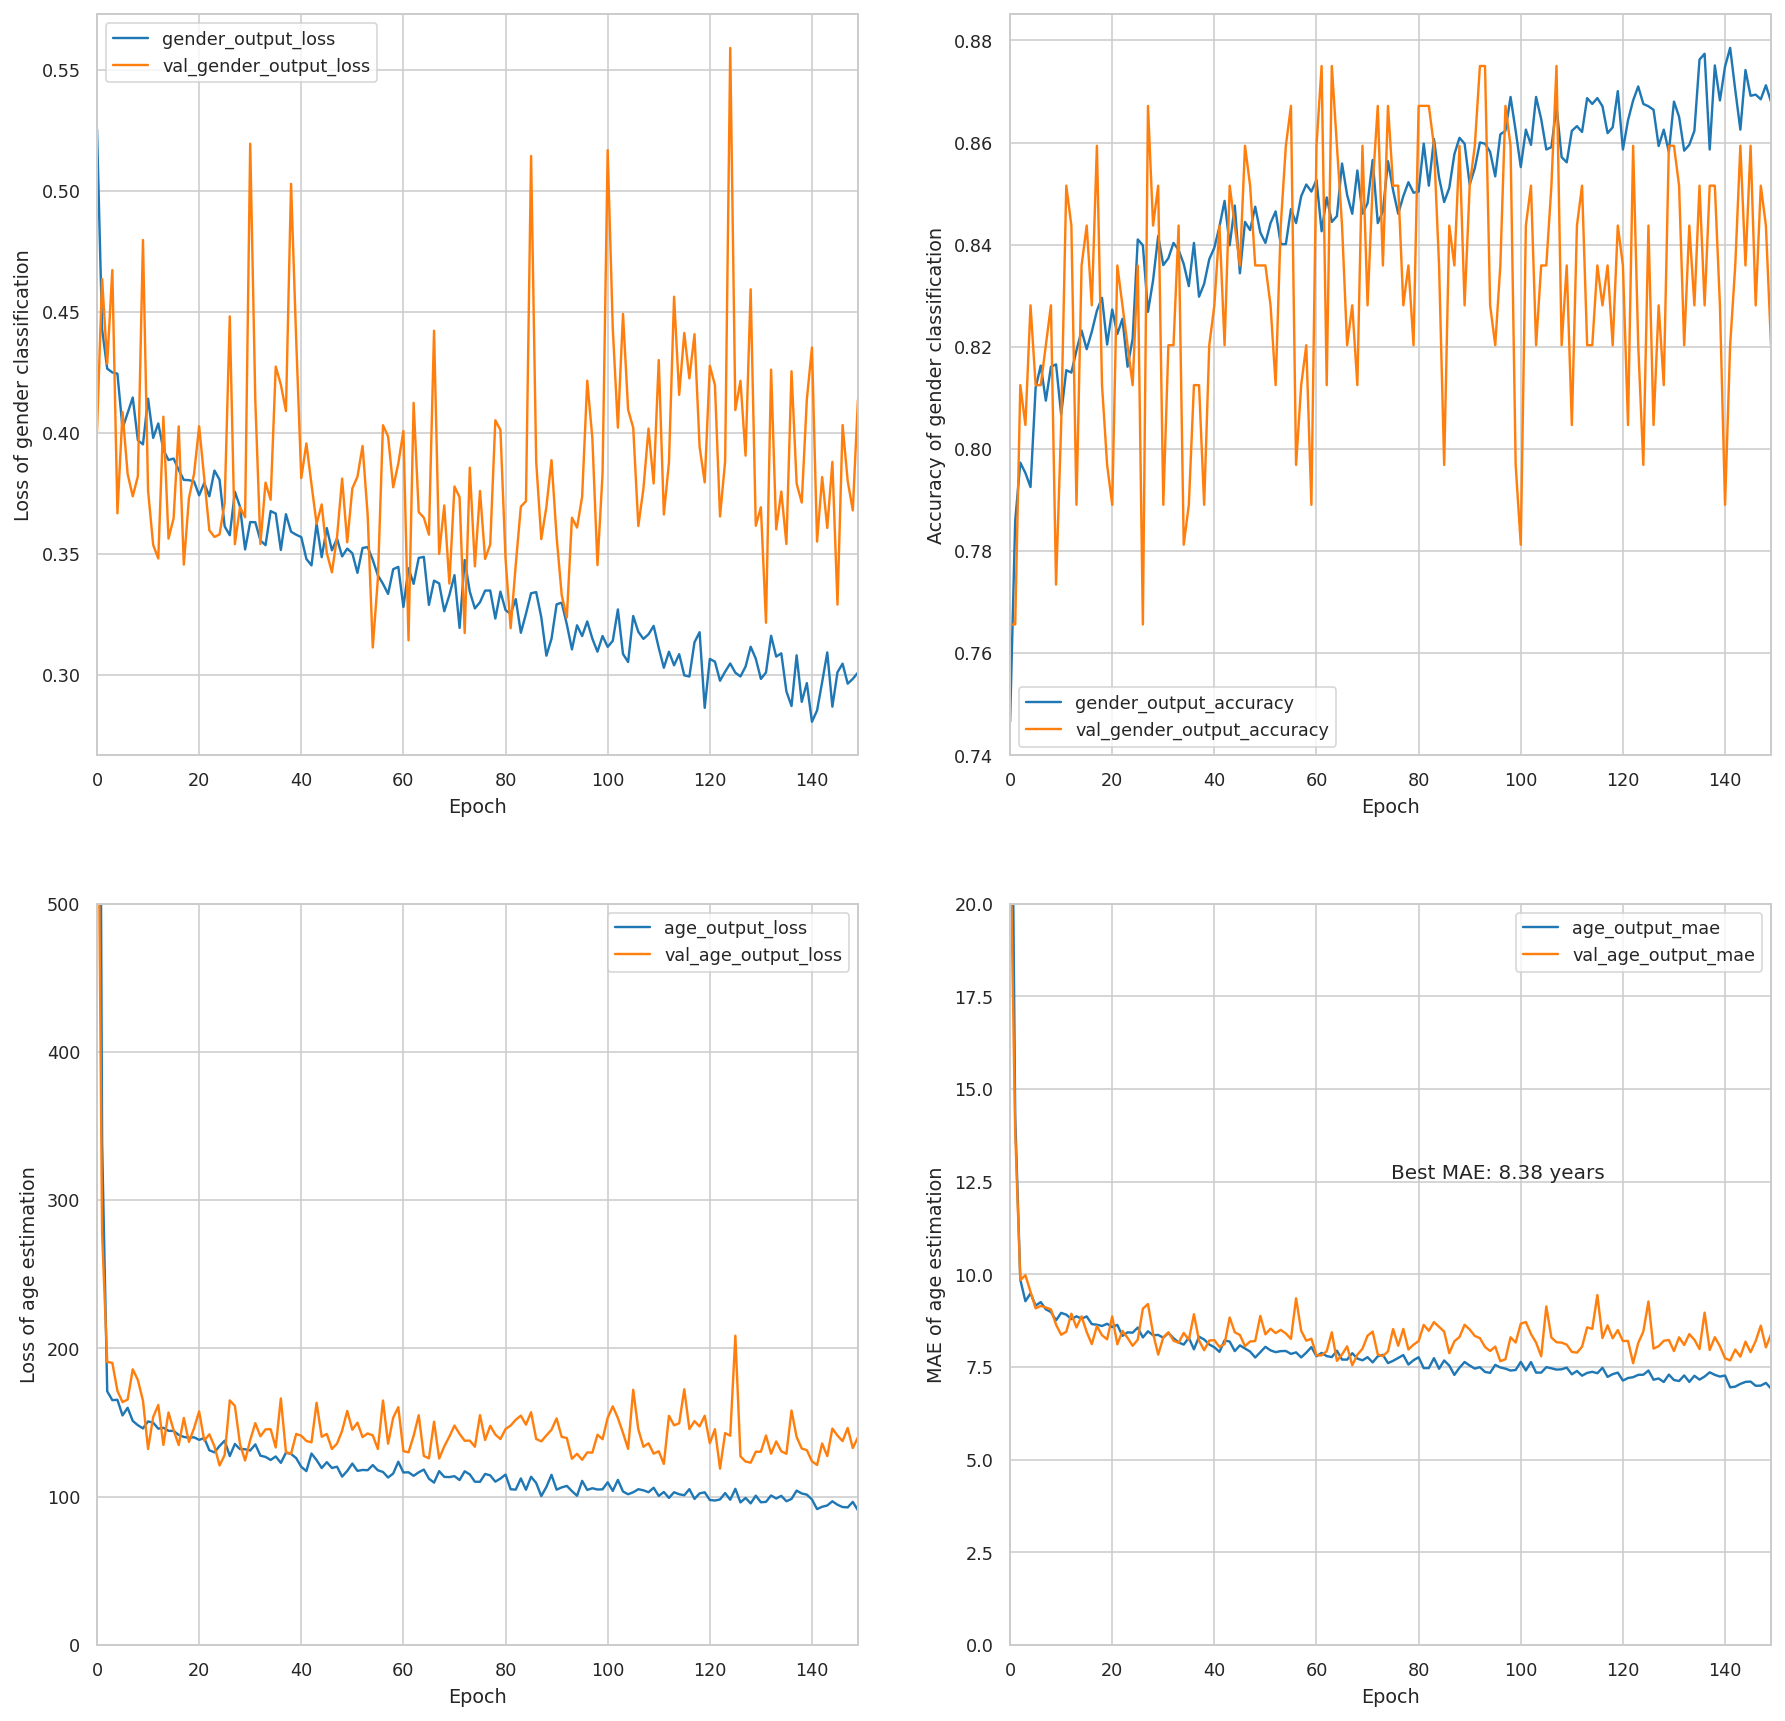

In [ ]:
df_history2 = pd.DataFrame(history.history)

# 2x2 Plot
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

epochs = df_history2.index
titles = \
  iter(['Loss of gender classification',
        'Accuracy of gender classification',
        'Loss of age estimation',
        'MAE of age estimation'])
y_labels = iter(['gender_output_loss', 'val_gender_output_loss',
                 'gender_output_accuracy', 'val_gender_output_accuracy',
                 'age_output_loss', 'val_age_output_loss', 
                 'age_output_mae', 'val_age_output_mae'])

for i in range(2):
  for j in range(2):
    y_1, y_2 = next(y_labels), next(y_labels)
    sns.lineplot(ax=ax[i,j], x=epochs, y=y_1, data=df_history2)
    sns.lineplot(ax=ax[i,j], x=epochs, y=y_2, data=df_history2)
    ax[i,j].legend([y_1, y_2])
    ax[i,j].set_ylabel(next(titles))
    ax[i,j].set_xlabel('Epoch')
    ax[i,j].margins(x=0)
    if (i==1) and (j==0):
      ax[i,j].set_ylim([0,500])
    if (i==1) and (j==1):
      ax[i,j].set_ylim([0,20])
      ax[i,j].annotate(f"Best MAE: {df_history2['val_age_output_mae'].iloc[-1]:.2f} years", (list(df_history2.index)[-1]/2, df_history2['val_age_output_mae'].iloc[-1]*1.5))

df_history2.tail()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy
